# 1. Hard SVM with 2 features and 10 samples

In [1]:

from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.utils import shuffle
data = datasets.load_iris()
from sklearn.preprocessing import StandardScaler

import jax.numpy as jnp
from jax import grad as fgrad
from jax import jit, vmap, jacfwd, jacrev, device_put
import numpy as np
from numpy.linalg import norm
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad
from scipy.integrate import solve_ivp
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import random
import jax

from copy import deepcopy

CUDA = torch.cuda.is_available()
mse = nn.MSELoss(reduction='none')
NUMERICAL_METHOD = 'RK45'

seed = 23

random.seed(seed)
# Set seed for NumPy
np.random.seed(seed)
# Set seed for PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU
# Set seed for JAX
key = jax.random.PRNGKey(seed)

In [2]:
def select_n_points(data_X, data_y, n):
    # Check if n is even
    if n % 2 != 0:
        raise ValueError("n must be an even number to select equal points from both classes.")

    # Separate the data into two classes: +1 and -1
    class_pos = data_X[data_y == 1]  # Class +1
    class_neg = data_X[data_y == -1]  # Class -1

    # Check if enough points exist in both classes
    if len(class_pos) < n // 2 or len(class_neg) < n // 2:
        raise ValueError("Not enough data points in one or both classes to select n points.")

    # Randomly select n//2 points from each class
    selected_pos = class_pos[np.random.choice(len(class_pos), n // 2, replace=False)]
    selected_neg = class_neg[np.random.choice(len(class_neg), n // 2, replace=False)]

    # Combine the selected points and their labels
    selected_X = np.vstack((selected_pos, selected_neg))
    selected_y = np.hstack((np.ones(n // 2), -np.ones(n // 2)))

    # Shuffle the selected points and labels
    selected_X, selected_y = shuffle(selected_X, selected_y, random_state=42)

    return selected_X, selected_y

In [3]:
X = data.data 
y = data.target
feature_names = data.feature_names

X = pd.DataFrame(X, columns=feature_names) 

# Filter out the rows where y is 2
mask = (y != 2)
X_filtered = X[mask]  # Only keep rows where y is not 2
y_filtered = y[mask]  # Only keep corresponding labels

# Encode y to be +1 and -1
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)
y_encoded[y_encoded == 0] = -1  # Replace 0 with -1

# Now X_filtered contains the features and y_encoded contains the -1 and +1 labels
data_X = X_filtered[['sepal length (cm)', 'sepal width (cm)']].to_numpy()
data_y = y_encoded

In [4]:
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

[Text(0.5, 0, 'sepal length (cm)'), Text(0, 0.5, 'sepal width (cm)')]

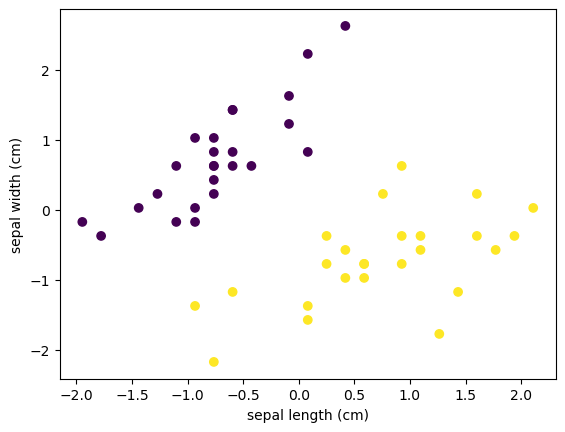

In [5]:
n = 50
selected_X, selected_y = select_n_points(data_X, data_y, n)
scaler = StandardScaler()
selected_X = scaler.fit_transform(selected_X)
_, ax = plt.subplots()
scatter = ax.scatter(selected_X[:, 0], selected_X[:, 1], c=selected_y)
ax.set(xlabel='sepal length (cm)', ylabel='sepal width (cm)')

In [6]:
# Define the plotting function
def plot_svm_decision_boundary(X, y, w, b, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Plot decision boundary
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    # Use only the selected features for the decision boundary
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = np.dot(grid, w[[feature_x_idx, feature_y_idx]]) + b
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])
    
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.legend()
    plt.title('Hard Margin SVM Decision Boundary')
    plt.show()
    
# Define the modified plotting function to plot two decision boundaries
def plot_svm_decision_boundary_confrontation(X, y, w_1, b_1, w_2, b_2, feature_x_idx, feature_y_idx):
    plt.figure(figsize=(8, 6))
    
    # Plot the two classes
    plt.scatter(X[y > 0][:, feature_x_idx], X[y > 0][:, feature_y_idx], c='b', label='Iris versicolor')
    plt.scatter(X[y < 0][:, feature_x_idx], X[y < 0][:, feature_y_idx], c='r', label='Iris setosa')

    # Create mesh grid for decision boundaries
    x_min, x_max = X[:, feature_x_idx].min() - 1, X[:, feature_x_idx].max() + 1
    y_min, y_max = X[:, feature_y_idx].min() - 1, X[:, feature_y_idx].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # First model's decision boundary (Ground Truth) in orange with highlight effect (thicker and transparent)
    Z1 = np.dot(grid, w_1[[feature_x_idx, feature_y_idx]]) + b_1
    Z1 = Z1.reshape(xx.shape)
    ground_truth = plt.contour(xx, yy, Z1, colors='purple', levels=[0], alpha=0.3, linewidths=5, linestyles=['-'])
    plt.contour(xx, yy, Z1, colors='purple', levels=[-1, 1], alpha=0.3, linewidths=3, linestyles=['--'])
    
    # Second model's decision boundary (ODE Solution) in purple
    Z2 = np.dot(grid, w_2[[feature_x_idx, feature_y_idx]]) + b_2
    Z2 = Z2.reshape(xx.shape)
    ode_solution = plt.contour(xx, yy, Z2, colors='green', levels=[0], alpha=0.8, linewidths=2, linestyles=['-'])
    plt.contour(xx, yy, Z2, colors='green', levels=[-1, 1], alpha=0.8, linewidths=1.5, linestyles=['--'])
    
    # Add the two main lines to the legend
    h1, _ = ground_truth.legend_elements()
    h2, _ = ode_solution.legend_elements()
    legend_elements = [h1[0], h2[0], 
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=10),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=10)]
    legend_labels = ['Ground Truth', 'ODE Solution', 'Iris versicolor', 'Iris setosa']
    plt.legend(legend_elements, legend_labels, loc='upper right')
    
    # Add labels, title, and show the plot
    plt.xlabel(f'sepal length (cm)')
    plt.ylabel(f'sepal width (cm)')
    plt.title('SVM Decision Boundaries')
    plt.show()

In [7]:
def adjust_label_positions(positions, min_distance=0.02):
    """Adjust vertical positions of labels to avoid overlap."""
    sorted_positions = sorted(enumerate(positions), key=lambda x: x[1])
    adjusted_positions = positions.copy()
    
    for i in range(1, len(sorted_positions)):
        curr_idx, curr_pos = sorted_positions[i]
        prev_idx, prev_pos = sorted_positions[i-1]
        
        if curr_pos - prev_pos < min_distance:
            adjusted_positions[curr_idx] = prev_pos + min_distance
    
    return adjusted_positions

def plot_ode_system(t_values, y_values):
    plt.figure(figsize=(8, 6))
    # Enable LaTeX rendering
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Plot each line and prepare label information
    labels = [f'w_{i}' for i in range(1,3)] + ['b'] + [f'u_{i}' for i in range(1, 11)]
    colors = plt.cm.rainbow(np.linspace(0, 1, len(labels)))
    label_positions = []

    for i, (label, color) in enumerate(zip(labels, colors)):
        line = plt.plot(t_values, y_values[i, :], label=label, color=color)[0]
        label_positions.append(y_values[i, -1])

    # Adjust label positions
    y_min, y_max = np.min(y_values), np.max(y_values)
    y_range = y_max - y_min
    min_distance = 0.02 * y_range  # 2% of y-range as minimum distance
    adjusted_positions = adjust_label_positions(label_positions, min_distance)

    # Add adjusted labels with increased font size and space
    fontsize = 14  # Adjust the font size here
    x_offset = 1  # Space to move the label away from the line
    
    for i, (label, color, position) in enumerate(zip(labels[:3], colors[:3], adjusted_positions[:3])):
        math_label = f"${label}$"  # Add space with LaTeX's \quad
        x_end = t_values[-1]
        plt.text(x_end + x_offset, position, f' {math_label}', verticalalignment='center', 
                 horizontalalignment='left', color=color, fontsize=fontsize)

    plt.xlabel('Time', fontsize=fontsize)
    plt.ylabel('y(t)', fontsize=fontsize)
    plt.title('ODE System Solution', fontsize=fontsize)
    plt.grid(False)

    # Adjust the plot limits to make room for labels
    plt.xlim(t_values[0], t_values[-1] * 1.1)  # Extend x-axis by 10%
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)  # Extend y-axis by 10% on both ends

    plt.tight_layout()
    plt.show()

Time: 0.0952155590057373
Optimal objective value: 3.509303233699906
SCS solver iterations: 350
SCS solve time: 0.029848078
SCS setup time: 0.037353091
Optimal w:  [ 1.93996577 -1.80420045]
Optimal b:  [0.328525]
Dual variables (Lagrange multipliers): [ 0.          3.50930322  0.          0.          2.95766996  0.
 -0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
 -0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.55163269
  0.          0.          0.          0.          0.          0.
  0.          0.        ]
Constraints: [-2.3278673   0.00000159 -0.91803294 -1.7704895  -0.00000259 -1.2786884
 -1.639344   -1.5409847  -0.9508194  -2.4918046  -1.2131145  -2.131149
 -0.49180472 -3.3770528  -1.8688527  -0

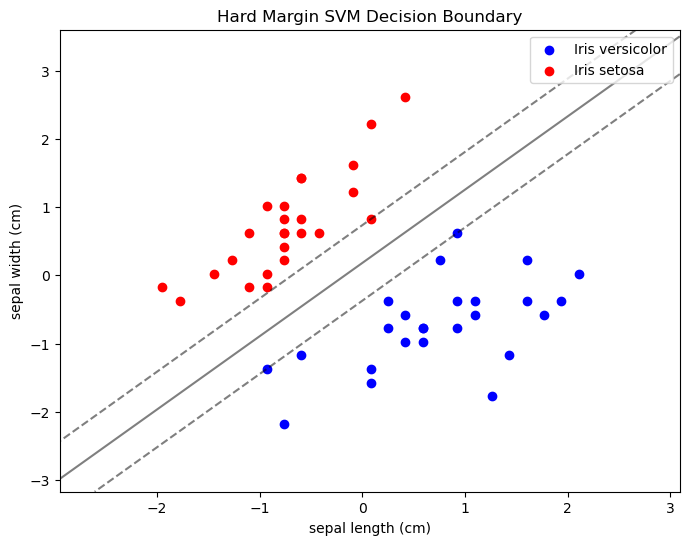

In [8]:
import cvxpy as cp
import numpy as np
import time

w = cp.Variable(2)
b = cp.Variable(1)

objective = cp.Minimize((1/2)*cp.norm(w, 2)**2)

constraints = [
    cp.multiply(selected_y, cp.matmul(selected_X, w) + b) >= 1,
]

problem = cp.Problem(objective, constraints)

t0 = time.time()
problem.solve(solver='SCS')
solve_time = time.time() - t0

# Get solver stats
solver_stats = problem.solver_stats
print('Time:', solve_time)
print('Optimal objective value:', problem.value)
print('SCS solver iterations:', solver_stats.num_iters)
print('SCS solve time:', solver_stats.solve_time)
print('SCS setup time:', solver_stats.setup_time)

# Get the values of the variables
print('Optimal w: ', w.value)
print('Optimal b: ', b.value)

# Get the dual variables
dual_variables = constraints[0].dual_value
print('Dual variables (Lagrange multipliers):', dual_variables)

g = [-selected_y[i] * (w.value @ selected_X[i] + b.value) + 1 for i in range(selected_y.shape[0])]
g_SCS = jnp.array(g).flatten()
print('Constraints:', g_SCS)

# Plotting
plot_svm_decision_boundary(selected_X, selected_y, w.value, b.value, 0, 1)

In [9]:
nw = selected_X.shape[1]
nb = 1
nx = nw + nb
nu = selected_X.shape[0]
NY = nx+nu

def f(x):
    w = x[:-1]
    output = (1/2) * jnp.linalg.norm(w, 2)**2
    return output

def g(x):
    w = x[:nw]
    b = x[nw]
    
    g = [-selected_y[i] * (w @ selected_X[i] + b) + 1 for i in range(selected_y.shape[0])]
    output = jnp.array(g)
    return output

df = fgrad(f) # jacobian of f
dg = jacrev(g) # jacobian of g

def P(xu): # projection mapping
    return xu

def ODE(t, xu):
    x, u = xu[:nx].reshape((nx, )), xu[nx:].reshape((nu, ))

    dx = df(x) + dg(x).T@jnp.clip(u+g(x), a_min=0)
    dx = -dx
    du = -u + jnp.clip(u+g(x), a_min=0)
    du = 0.5*du
    dxu = jnp.concatenate([dx, du], axis=0)
    return dxu

ODE = jit(ODE)

def evalutation(xu): # metric OuC(x_pred): check if inisde feasable region and return the objective value
    "return  f(x),    if g(x)<=0, f(x)=np.inf, if g(x)>0 "
    x, u= xu[:nx], xu[nx:]
    if (g(x)<=0.01).all():
        obj = f(x)
        #print('g(x) values:', g(x))
    else:
        obj = np.inf
        #print('g(x) values:', g(x))
    return obj

def constraints_diff(g_ODE, g_SCS):
    return jnp.abs(g_ODE - g_SCS).max()

In [10]:
def solve_ODE(xu0, T):
    sol = solve_ivp(ODE, [0., T], xu0, method=NUMERICAL_METHOD)
    result = P(sol.y[:, -1])
    print("objective:",evalutation(result))
    print("Constraints:",g(result[:nx]))
    diff = constraints_diff(g(result[:nx]), g_SCS)
    print("max diff:", diff.max(), "mean diff:", diff.mean())
    print("w diff:", jnp.abs(result[:nw] - w.value), "b diff:", jnp.abs(result[nw] - b.value))

    return sol, result

objective: 3.5075772
Constraints: [-2.3258872   0.00115916 -0.91767406 -1.7683412  -0.00117439 -1.2780681
 -1.6384621  -1.5410528  -0.9501438  -2.4914627  -1.2122355  -2.1310687
 -0.49234048 -3.3778262  -1.868084   -0.39403817 -1.4436435  -0.55728
 -1.9339166  -0.2934023  -1.8031445  -1.9654933  -1.1797657  -0.52481025
 -2.5865386  -0.49144748 -2.521599   -2.3917198  -1.3105378  -2.5239325
 -2.1319618  -1.7674482  -2.3267803  -4.981751   -2.228478   -1.868084
 -1.9988561  -0.16441624 -2.0336595  -1.2780681  -1.9005538   0.00205217
 -3.1148415  -1.0475531  -3.8031597  -3.77069    -0.62221956 -4.228493
 -1.508583   -2.3917198 ]
max diff: 0.0036211014 mean diff: 0.0036211014
w diff: [0.00032626 0.00130801] b diff: [0.00005385]


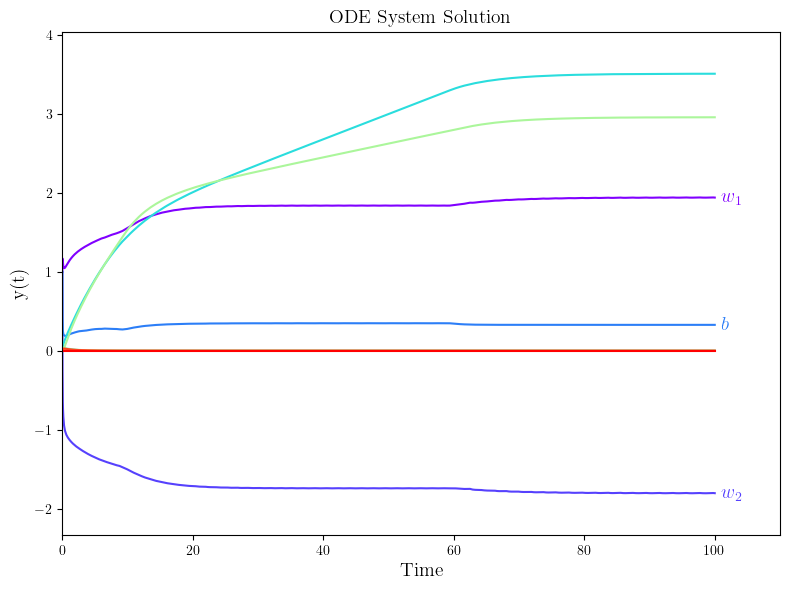

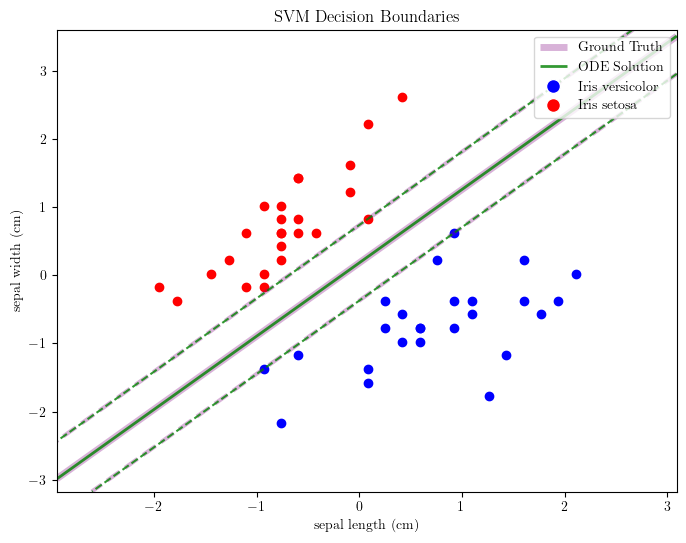

In [11]:
xu0 = jnp.zeros(NY)
xu0 = xu0.at[:nw + nb].set(1.0)

sol, result = solve_ODE(xu0, 100)

t_values = sol.t
y_values = sol.y

w_ode = result[:data_X.shape[1]]
b_ode = result[data_X.shape[1]]

plot_ode_system(t_values, y_values)

plot_svm_decision_boundary_confrontation(selected_X, selected_y, w.value, b.value, w_ode, b_ode, 0, 1)

In [12]:
t0 = time.time()
sol, result = solve_ODE(xu0, 20)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: inf
Constraints: [-2.1903245   0.07804354 -0.7631224  -1.598026    0.05272028 -1.1058124
 -1.4485025  -1.33636    -0.80050325 -2.3087294  -1.1248734  -1.9660393
 -0.3456706  -3.1125145  -1.7354919  -0.32735065 -1.2242174  -0.42043233
 -1.7164309  -0.28370744 -1.6607301  -1.8476344  -1.0874926  -0.38305146
 -2.3955488  -0.43949324 -2.320787   -2.1712635  -1.1431934  -2.3461103
 -1.8722167  -1.6918486  -2.0965018  -4.670179   -2.078182   -1.7354919
 -1.7911927  -0.04036139 -1.8538967  -1.1058124  -1.7728727  -0.01577908
 -2.881967   -0.9126458  -3.5299664  -3.4925854  -0.49519405 -3.947418
 -1.2989792  -2.1712635 ]
max diff: 0.31342745 mean diff: 0.31342745
w diff: [0.13348438 0.08987299] b diff: [0.01485324]
Time: 0.3547403812408447


In [13]:
t0 = time.time()
sol, result = solve_ODE(xu0, 50)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: inf
Constraints: [-2.2409074   0.06411619 -0.7932522  -1.6388476   0.03431755 -1.1413182
 -1.4893842  -1.3772864  -0.8306181  -2.3647783  -1.1593438  -2.0167122
 -0.37045452 -3.1847808  -1.780744   -0.35111427 -1.2651888  -0.4451863
 -1.7627183  -0.30197537 -1.7060121  -1.8928416  -1.1219779  -0.4078204
 -2.4470773  -0.46321192 -2.3723454  -2.2228818  -1.1786841  -2.402144
 -1.9239548  -1.731605   -2.1481502  -4.763874   -2.12881    -1.780744
 -1.83745    -0.05975446 -1.9046146  -1.1413182  -1.8181099  -0.0286412
 -2.9488125  -0.94271576 -3.6075785  -3.5702126  -0.519918   -4.030376
 -1.3399206  -2.2228818 ]
max diff: 0.21973228 mean diff: 0.21973228
w diff: [0.10158734 0.06297991] b diff: [0.02048685]
Time: 0.8236720561981201


In [14]:
t0 = time.time()
sol, result = solve_ODE(xu0, 100)
solve_time = time.time() - t0
print('Time:', solve_time)

objective: 3.5075772
Constraints: [-2.3258872   0.00115916 -0.91767406 -1.7683412  -0.00117439 -1.2780681
 -1.6384621  -1.5410528  -0.9501438  -2.4914627  -1.2122355  -2.1310687
 -0.49234048 -3.3778262  -1.868084   -0.39403817 -1.4436435  -0.55728
 -1.9339166  -0.2934023  -1.8031445  -1.9654933  -1.1797657  -0.52481025
 -2.5865386  -0.49144748 -2.521599   -2.3917198  -1.3105378  -2.5239325
 -2.1319618  -1.7674482  -2.3267803  -4.981751   -2.228478   -1.868084
 -1.9988561  -0.16441624 -2.0336595  -1.2780681  -1.9005538   0.00205217
 -3.1148415  -1.0475531  -3.8031597  -3.77069    -0.62221956 -4.228493
 -1.508583   -2.3917198 ]
max diff: 0.0036211014 mean diff: 0.0036211014
w diff: [0.00032626 0.00130801] b diff: [0.00005385]
Time: 1.745830774307251


# 3. The method

In [15]:
T=75.0

In [16]:
def g_batch(x):
    w = x[:, :nw]  # Extract w for each sample in the batch
    b = x[:, nw]   # Extract b for each sample in the batch

    # Compute g for each batch sample (2048) and constraint (10) using NumPy
    g = [[-selected_y[j] * (w[i] @ selected_X[j] + b[i]) + 1 for j in range(selected_y.shape[0])] for i in range(x.shape[0])]
    
    output = np.array(g)
    return output

In [17]:
class FNN(nn.Module):
    def __init__(self, y0):
        self.y0 = torch.tensor(y0, dtype=torch.float)
        if CUDA:
            self.y0 = self.y0.cuda()
        super(FNN, self).__init__()
        self.linear1 = nn.Linear(1, NEURONS).cuda()
        self.linearL = []
        for _ in range(LAYERS-1):
            self.linearL.append(nn.Linear(NEURONS, NEURONS).cuda())
        self.linear2 = nn.Linear(NEURONS, NY).cuda()

    def forward(self, x):
        t = x.cuda()
        x = torch.tanh(self.linear1(x))
        for i in range(LAYERS-1):
            x = torch.tanh(self.linearL[i](x))
        x = self.linear2(x)
        x = self.y0 + (1 - torch.exp(-(t-0)))*x
        return x


class NN_NOP:
    def __init__(self, y0, time_range, P, ODE, C_epsilon): # P: projection mapping, ODE, C_epsilon: OuC metric
        self.y0 = np.array(y0)
        self.time_range = time_range # [0, 10]
        self.T = time_range[-1] # T=10
        self.P = P
        self.ODE = ODE
        self.C_epsilon = C_epsilon
        self.vODE = vmap(ODE, in_axes=(0, 0), out_axes=0)
        #self.numerical_method() # solve analyicallly the ODE

    def numerical_method(self):
        sol = solve_ivp(self.ODE, self.time_range, self.y0, method=NUMERICAL_METHOD)
        self.y_T_ODE = sol.y[:, -1] # get last value of the solution
        self.y_T_ODE = self.P(self.y_T_ODE) # project it
        self.y_T_ODE = np.array(self.y_T_ODE)
        self.epsilon_ODE = self.C_epsilon(self.y_T_ODE) # calculate OuC (f(x))

    def NN_method(self, weights=None, t_L=None):
        """
        train the nn, store the following four

        L_loss:  list, loss of batch during training
        L_epsilon: list, epsilon_best during training
        L_y_T: list, yT during training
        net_best:  the best neural network model during training
        """
        net = FNN(self.y0)
        if weights is not None:
            net.load_state_dict(weights.state_dict())
        if CUDA:
            net = net.cuda()
            
        optimizer = Adam(net.parameters(), lr=LR) # ========> 0.001 not looks good
        i = 0
        L_loss = []
        L_epsilon = []
        L_epsilon_curr = []
        L_y_T = []
        L_y_T_curr = []
        #L_y_iterations = []
        t0 = time.time()
        while True:
            # Update, L_epsilon, L_yT, net_best
            T = self.T*torch.ones((1, 1), dtype=torch.float)
            if CUDA:
                T = T.cuda()
            y_T = self.P_multiple(T, net) # get the output of the nn at T (last time)
            L_y_T_curr.append(y_T)

            epsilon_current = self.C_epsilon(y_T) # calculate OuC (f(x))
            L_epsilon_curr.append(epsilon_current)
            if i==0: # if first iteration
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
                #L_y_iterations.append(self.y_iteration(net_best))
            # if i==10:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==20:
            #     L_y_iterations.append(self.y_iteration(net_best))
            # if i==ITERATIONS-1:
            #L_y_iterations.append(self.y_iteration(net_best)) # store the output of the best nn across the time
            if epsilon_current < epsilon_best:
                epsilon_best = epsilon_current
                y_T_best = y_T
                #y_T_error = np.linalg.norm(self.y_T_ODE-y_T_best, ord=2)
                net_best = deepcopy(net)
            L_epsilon.append(epsilon_best) # store the best OuC
            L_y_T.append(y_T_best) # store the best output of the nn at T

            # TRAIN MODEL
            # Prepare input t, torch.tensor (NBATCH, 1)
            if t_L is not None:
                t = t_L[i]
            else:
                t = np.random.uniform(0, self.T, (NBATCH, 1))
            t = torch.tensor(t, dtype=torch.float, requires_grad=True)
            if CUDA:
                t = t.cuda()
            # Learning, L_loss
            loss = self.loss_compute(t, net)
            loss.backward()
            L_loss.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            # Monitor
            if i%100==0:
            # if i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99]:
                #print(f'T: {self.T}, y_T_ODE: {self.y_T_ODE.round(4)}, epsilon_ODE: {self.epsilon_ODE :.4f},  Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}, ||y_T_ODE-y_T_best||_2: {y_T_error :.4f}')
                #print(f'T: {self.T}, Iteration: {i}, Loss: {loss.item() :.4f},  epsilon_best: {epsilon_best :.4f}, y_T: {y_T_best.round(4)}')
                pass
            i = i+1
            
            torch.cuda.empty_cache()
            
            if i==ITERATIONS:
                break

        return L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time.time()-t0

    def loss_compute(self, t, net):
        # nn output xu, torch.tensor (NBATCH, nxu)
        y = net(t)

        # => Get ODE derivatives
        # True dxu, torch.tensor (NBATCH, nxu)
        t_cpu = t.cpu().detach().numpy()
        y_cpu = y[:, :].cpu().detach().numpy()
        dy = self.vODE(t_cpu, y_cpu)
        dy = np.array(dy)
        
        dy = torch.tensor(dy, dtype=torch.float)
        if CUDA:
            dy = dy.cuda()

        # => Get NN derivatives (autograd)
        # Predicted pdxu, torch.tensor (NBATCH, nxu)
        pdy = []
        for j in range(NY): # for all outputs node (for all variables)
            # y[:, [j]]: outputs of the nn for the j-th variable (all t of the batch), t: inputs of the nn, grad_outputs: scale the gradients to facilitate the compuation of the jacobian, Craete_graph: to compute higer order derivatives
            pdyi = grad(y[:, [j]], t, grad_outputs=torch.ones_like(y[:, [j]]), create_graph=True)[0] # torch autograd shape [NBATCH, 1]
            pdy.append(pdyi)
        pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]
        #pdy = torch.cat(pdy, dim=1) # for makning it a tensor: [NBATCH, NY]

        # 1. Dynamics loss
        # Compute loss, torch.tensor a float
        dynamics_loss = mse(dy, pdy) # [NBATCH, NY]
        dynamics_loss = torch.sum(dynamics_loss, axis=1) # [NBATCH]
        dynamics_loss = torch.exp(-WEIGTHING*((t / T).detach().reshape((-1, ))**2))*dynamics_loss  # proprity smaller t
        dynamics_loss = torch.mean(dynamics_loss, axis=0)
        
        # 2. Constraint violation penalty with smooth weighting
        FIXED_PENALTY = 1.0
        PENALTY_SCALE = 2.0
        epsilon = 1e-3
        
        x = y[:, :nx].cpu().detach().numpy()
        g_values = torch.tensor(g_batch(x)).cuda()
        
        penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
        
        logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()
        
        constraint_loss = torch.sum(logarithmic_penalty, axis=1) # [NBATCH]
        constraint_weight  = torch.exp(-WEIGTHING * ((1 - t / T).detach().reshape((-1,))**2))
        constraint_loss = constraint_weight * constraint_loss
        constraint_loss = torch.mean(constraint_loss)
        
        # 4. Total loss
        loss = dynamics_loss + constraint_loss * CONSTRAINT_WEIGHT
        
        return loss

    def P_multiple(self, t, net): # get the projection of the output of the nn (for multiple t)
        y = net(t)
        y = y.reshape((-1, )).cpu().detach().numpy()
        output = self.P(y)
        output = np.array(output)
        return output

    def y_iteration(self, net): # get the ODE system estiamtion across the time
        # For L_y
        t = torch.arange(0, self.T, 0.1).reshape((-1, 1))
        if CUDA:
            t = t.cuda()
        y = [self.P_multiple(t[i].reshape((1,1)), net) for i in range(t.shape[0])]
        y = torch.tensor(np.array(y)).cpu().detach().numpy()

        return y # [T, NY]


In [18]:
y0 = np.zeros(NY)
y0[:nw + nb] = 1.0

In [19]:
def try_layers(l_list, n, lr):
     NEURONS = n
     LR = lr
     res = []
     for l in l_list:
          LAYERS = l
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_neurons(n_list, l, lr):
     LAYERS = l
     LR = lr
     res = []
     for n in n_list:
          NEURONS = n
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'MSE soltion: ': mse_, 'time': time})
     return res

def try_lr(lr_list, l, n):
     LAYERS = l
     NEURONS = n
     res = []
     for lr in lr_list:
          LR = lr
          example = NN_NOP(y0, [0, T], P, ODE, evalutation) # init
          L_epsilon, L_epsilon_curr, L_y_T, L_y_T_curr, net_best, L_loss, time = example.NN_method() # train
          mse_ = get_error({'net': net_best})
          non_inifinty_ratio = len([num for num in L_epsilon_curr if not  np.isinf(num)]) / len(L_epsilon_curr)
          print('LAYERS:', l, 'NEURONS:', n, 'LR:', lr, 'epsilon:', L_epsilon[-1], 'MSE solution:', mse_, 'ratio:', non_inifinty_ratio, 'time:', time)
          res.append({'layers': l, 'neurons': n, 'lr': lr, 'net': net_best, 'L_epsilon': L_epsilon, 'L_epsilon_curr': L_epsilon_curr, 'mse': mse_, 'ratio': non_inifinty_ratio, 'time': time})
     return res

def plot_results(res, y_max=50):
    fig, axes = plt.subplots(1, len(res), figsize=(20, 6))
    y_min = 0
    for i in range(len(res)):
        # Plot on the first subplot
        axes[i].plot(res[i]['L_epsilon'], marker='o', linestyle='-', label='OuC metric best', markersize=1)
        axes[i].plot(res[i]['L_epsilon_curr'], marker='o', linestyle='-', label='OuC metric current', markersize=1)
        axes[i].set_xlabel('iteration')
        axes[i].set_ylabel('OuC metric')
        axes[i].set_title(f'l={res[i]["layers"]}, n={res[i]["neurons"]}, lr={res[i]["lr"]}')
        axes[i].legend()
        axes[i].grid(True)
        axes[i].set_ylim(y_min, y_max)
        axes[i].set_xlim(0, ITERATIONS)
    # Adjust layout to prevent overlapping
    plt.tight_layout()
    # Show the plot
    plt.show()

def plot_result_confrontation(res):
     plt.figure(figsize=(6, 5))
     for r in res:
          plt.plot(r['L_epsilon'], marker='o', linestyle='-', label=f'l={r["layers"]}, n={r["neurons"]}, lr={r["lr"]}', markersize=1)
     # Add labels, title, legend and grid
     plt.xlabel('iteration')
     plt.ylabel('OuC metric')
     plt.title('Numbers of layers')
     plt.legend()  # Show the legend to distinguish the datasets
     plt.grid(False)
     plt.show()

def plot_hyperplane(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     w_net = epsilon[0][:selected_X.shape[1]]
     b_net = epsilon[0][selected_X.shape[1]]
     # Plotting
     plt.figure(figsize=(10, 8))
     plt.scatter(selected_X[selected_y > 0][:, 0], selected_X[selected_y > 0][:, 1], c='b', label='Class 1')
     plt.scatter(selected_X[selected_y < 0][:, 0], selected_X[selected_y < 0][:, 1], c='r', label='Class -1')

     # Plot the decision boundary
     x_min, x_max = selected_X[:, 0].min() - 1, selected_X[:, 0].max() + 1
     y_min, y_max = selected_X[:, 1].min() - 1, selected_X[:, 1].max() + 1
     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
     Z = np.dot(np.c_[xx.ravel(), yy.ravel()], w_net) + b_net
     Z = Z.reshape(xx.shape)
     plt.contour(xx, yy, Z, colors='k', levels=[0], alpha=0.5, linestyles=['-'])

     # Plot the margins
     plt.contour(xx, yy, Z, colors='k', levels=[-1, 1], alpha=0.5, linestyles=['--'])

     plt.xlabel('Feature 1')
     plt.ylabel('Feature 2')
     plt.legend()
     plt.title('Hard Margin SVM Decision Boundary')
     plt.show()

def print_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]]).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     # Print the absolute differences for all weights and bias
     print('w absolute differences:', w_abs_diff)
     print('b absolute difference:', b_abs_diff)

     # Print the MSE
     print('\nMSE between the two solutions:', mse_)

def get_error(r):
     net = r['net']
     epsilon = net(torch.tensor([[T]], dtype=torch.float32).cuda()).cpu().detach().numpy()
     # Split epsilon into weights and bias
     w_net = epsilon[0][:selected_X.shape[1]]  # All weights
     b_net = epsilon[0][selected_X.shape[1]]   # Bias

     # Calculate absolute differences for weights and bias
     w_abs_diff = np.abs(w_ode - w_net)         # Vector for all weights
     b_abs_diff = np.abs(b_ode - b_net)      # Single value for bias

     # Calculate squared differences
     w_sq_diff = w_abs_diff ** 2               # Vector for squared differences of weights
     b_sq_diff = b_abs_diff ** 2               # Squared difference for bias

     # Calculate the Mean Squared Error (MSE)
     mse_ = (np.sum(w_sq_diff) + b_sq_diff) / (len(w_sq_diff) + 1)

     return mse_

In [20]:
T=75.0
NBATCH = 512
ITERATIONS = 1000
NEURONS=100
LR=0.01
LAYERS=2
hyperparameter_combinations = []

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 5.8780417 MSE solution: 0.267390732328523 ratio: 0.009 time: 228.10384702682495
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 3.091651656906299 ratio: 0.0 time: 235.40276336669922
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 5.0029736 MSE solution: 0.11773226679496081 ratio: 0.019 time: 232.84381532669067


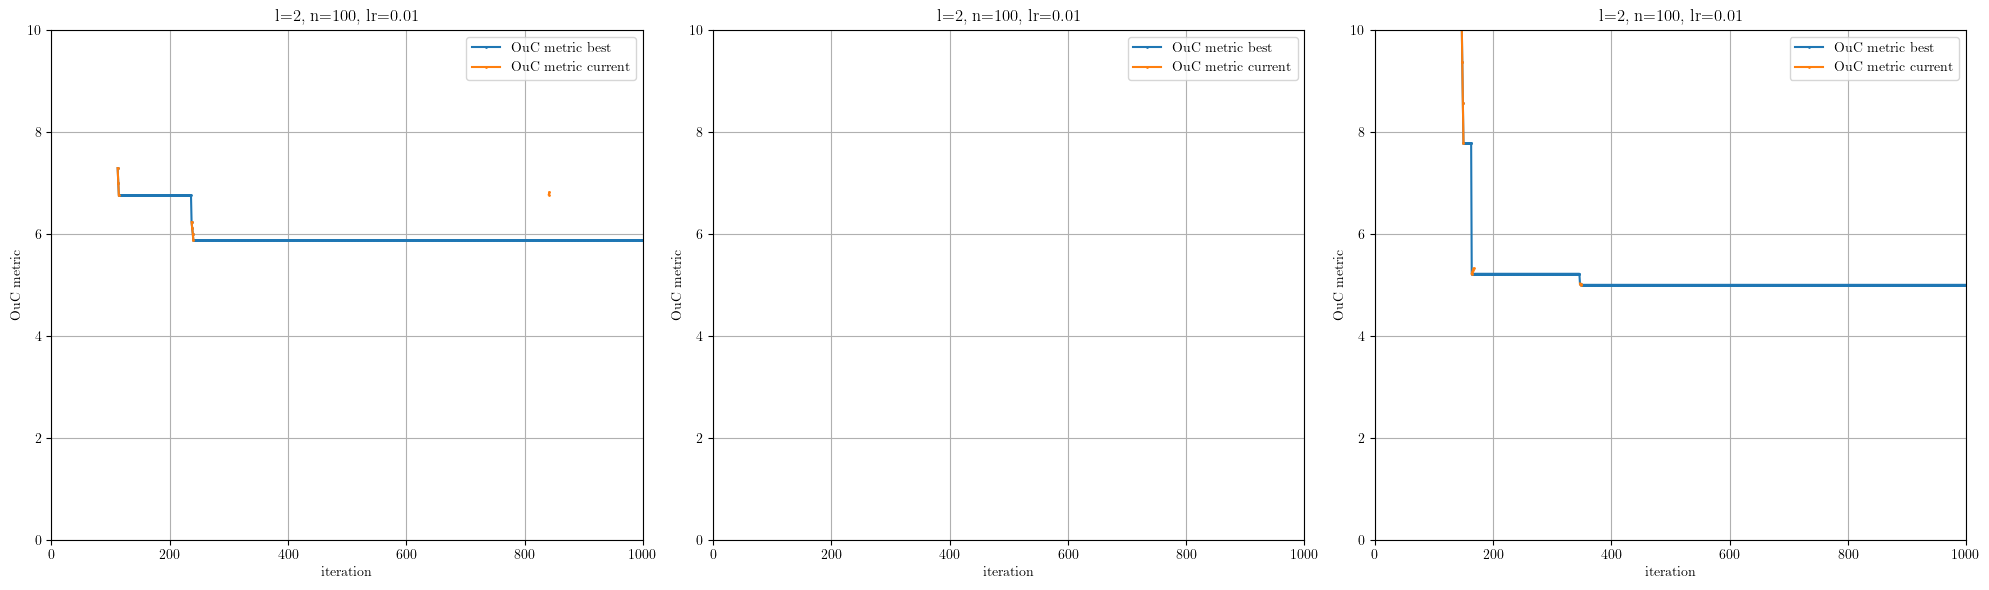

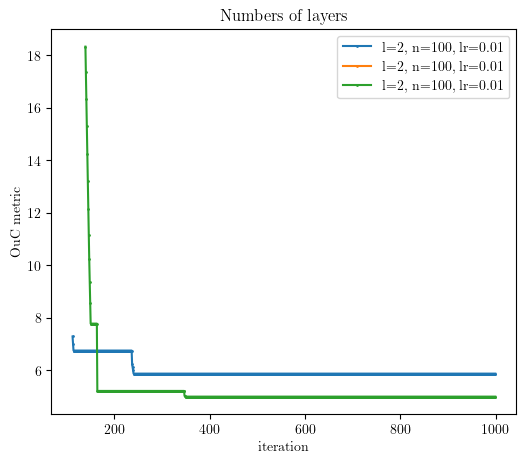

In [21]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.6567202 MSE solution: 0.003908117309330487 ratio: 0.006 time: 240.70006704330444
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 5.032242 MSE solution: 0.1155127591363081 ratio: 0.019 time: 236.37615442276
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.949051 MSE solution: 0.01606922029494697 ratio: 0.03 time: 246.707834482193


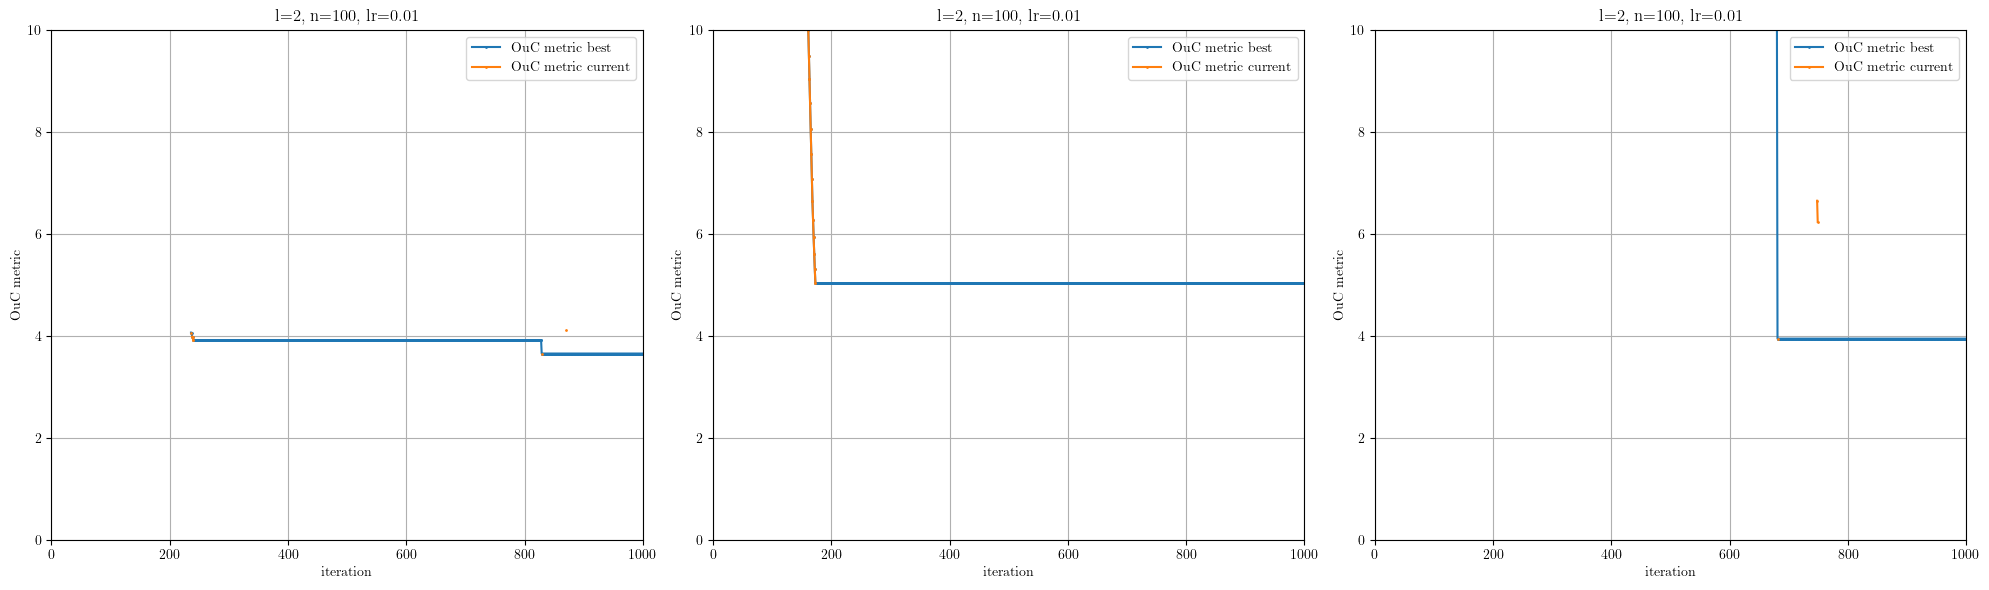

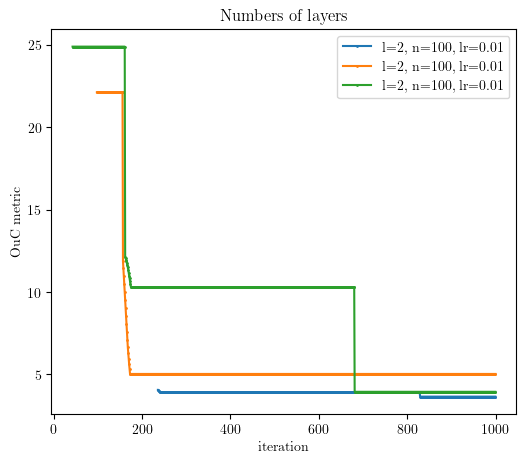

In [22]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 3.0746735590763756 ratio: 0.0 time: 236.51057720184326
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.6087072 MSE solution: 0.0005933473542622226 ratio: 0.026 time: 228.7853033542633
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.145024 MSE solution: 0.03166494676852303 ratio: 0.018 time: 223.9995572566986


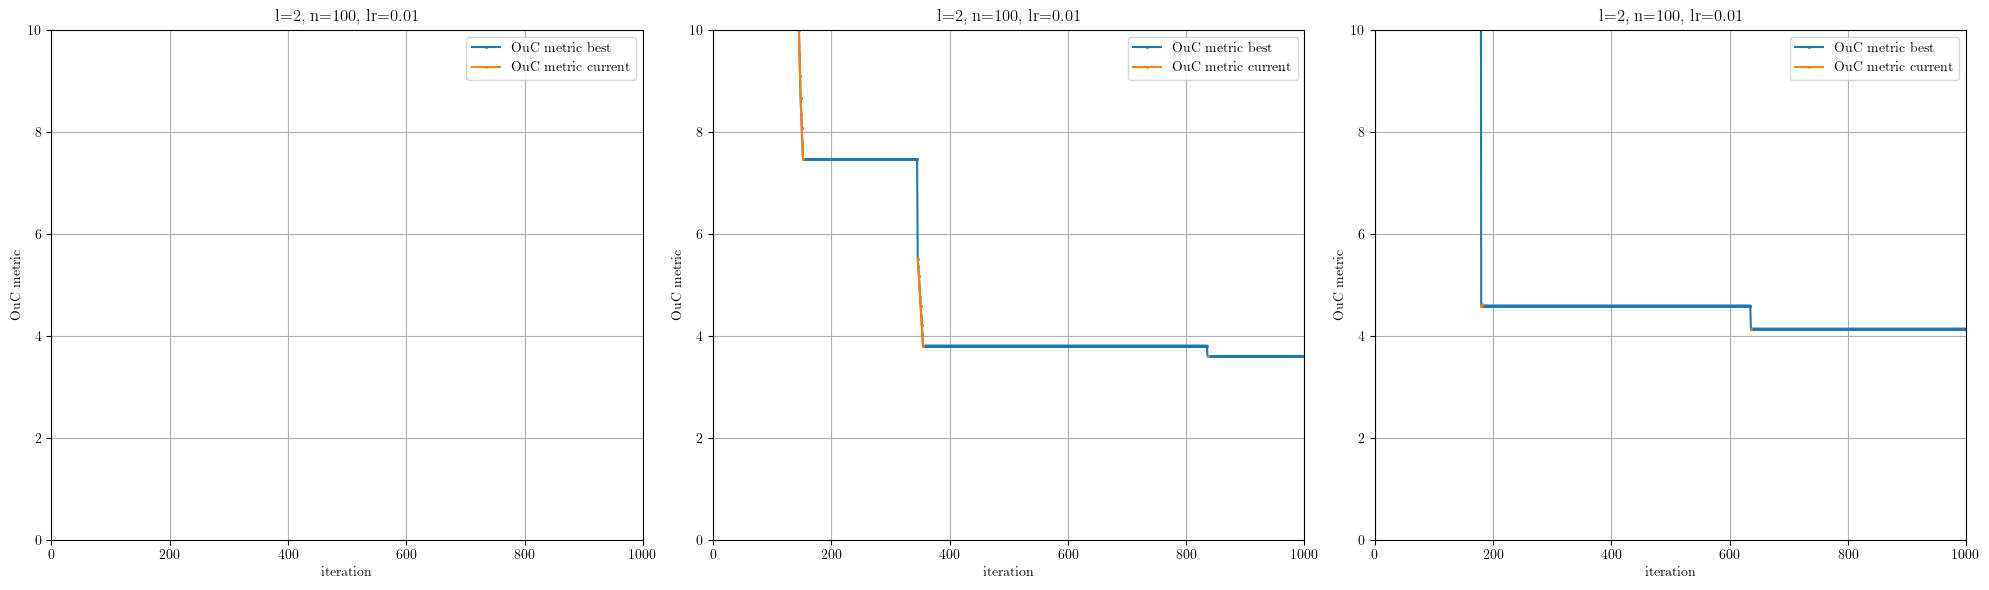

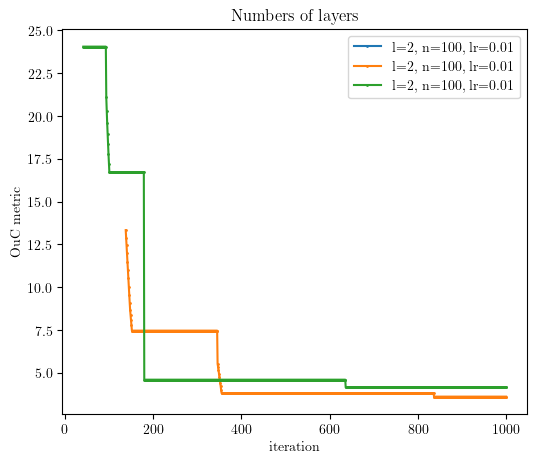

In [23]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.3965135 MSE solution: 0.04525333150921981 ratio: 0.002 time: 231.94858360290527
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.992909 MSE solution: 0.01764361467521937 ratio: 0.012 time: 232.83419632911682
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.865918 MSE solution: 0.11292204380372423 ratio: 0.006 time: 232.2551829814911


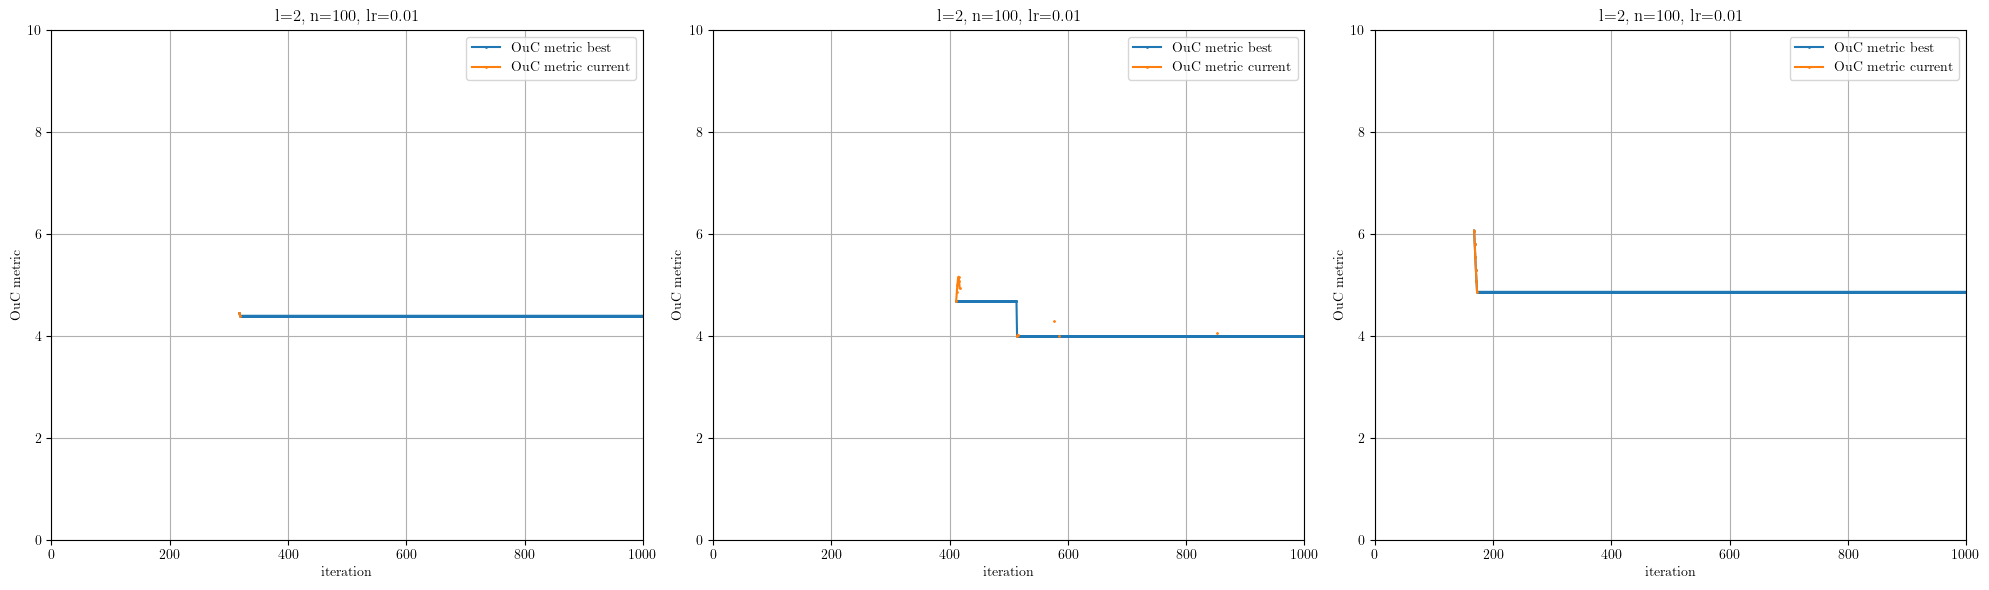

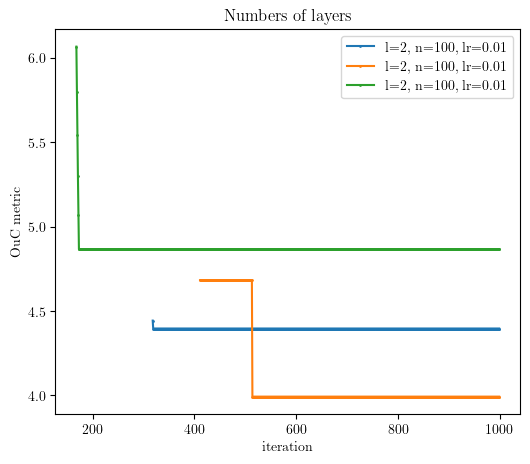

In [24]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.6414297 MSE solution: 0.0015030920393161618 ratio: 0.017 time: 235.41206288337708
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.8551493 MSE solution: 0.01786686842343027 ratio: 0.03 time: 232.1701865196228
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.9427931 MSE solution: 0.009391035528014744 ratio: 0.002 time: 232.17115426063538


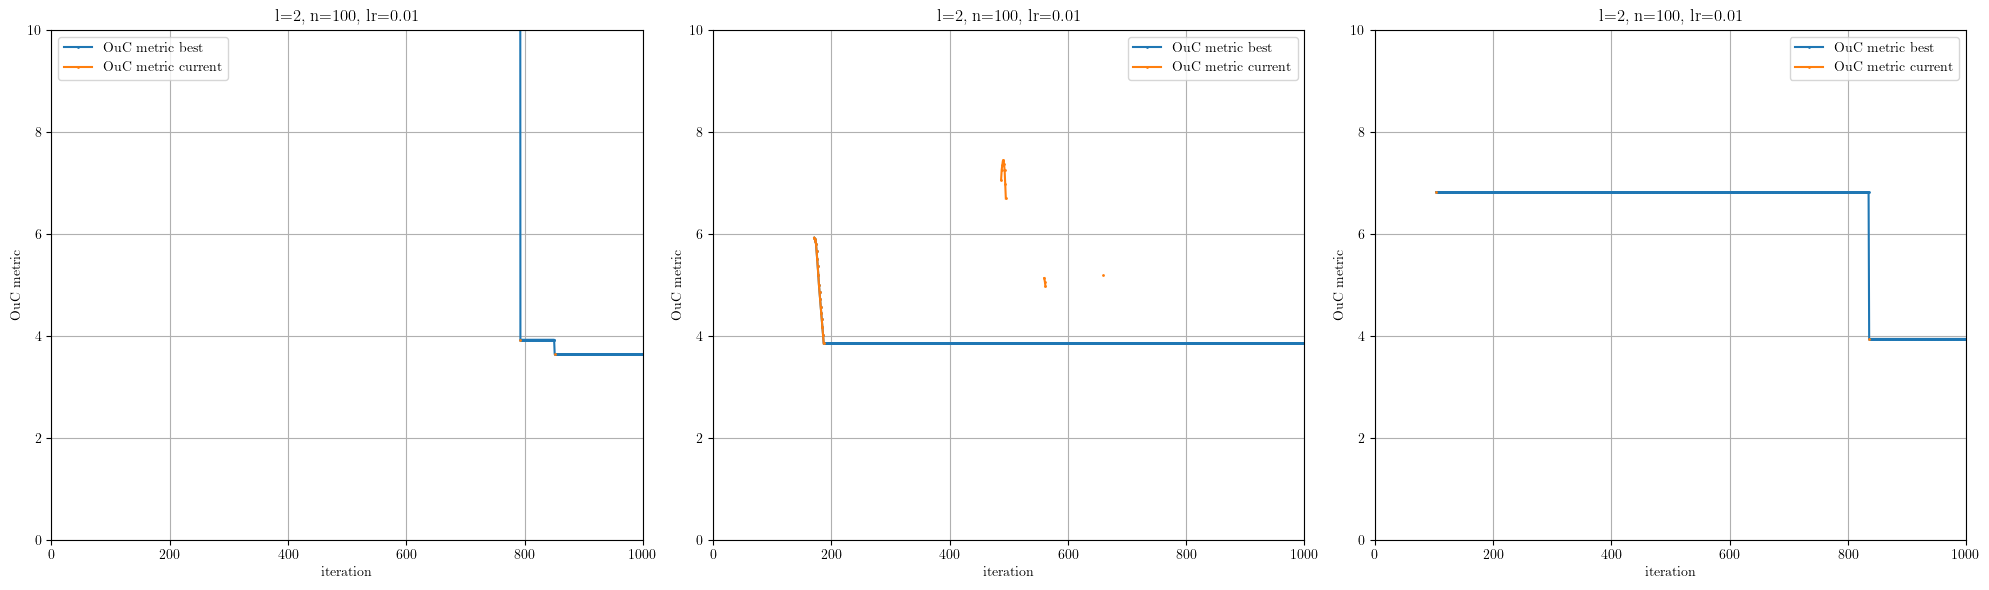

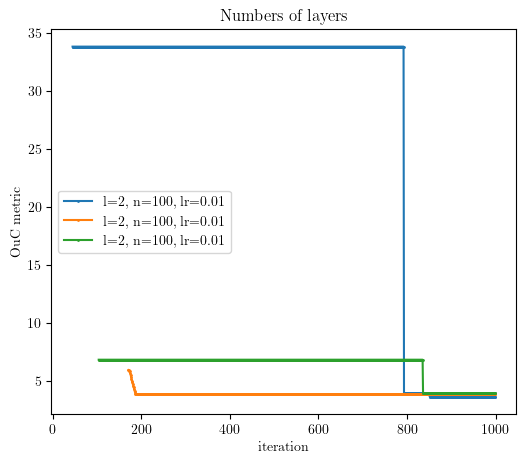

In [25]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.3472753 MSE solution: 0.03287767767243206 ratio: 0.001 time: 234.4348828792572
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.16281 MSE solution: 0.03552374683530498 ratio: 0.018 time: 228.41631364822388
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 34.58862 MSE solution: 13.006781696247531 ratio: 0.008 time: 224.02357745170593


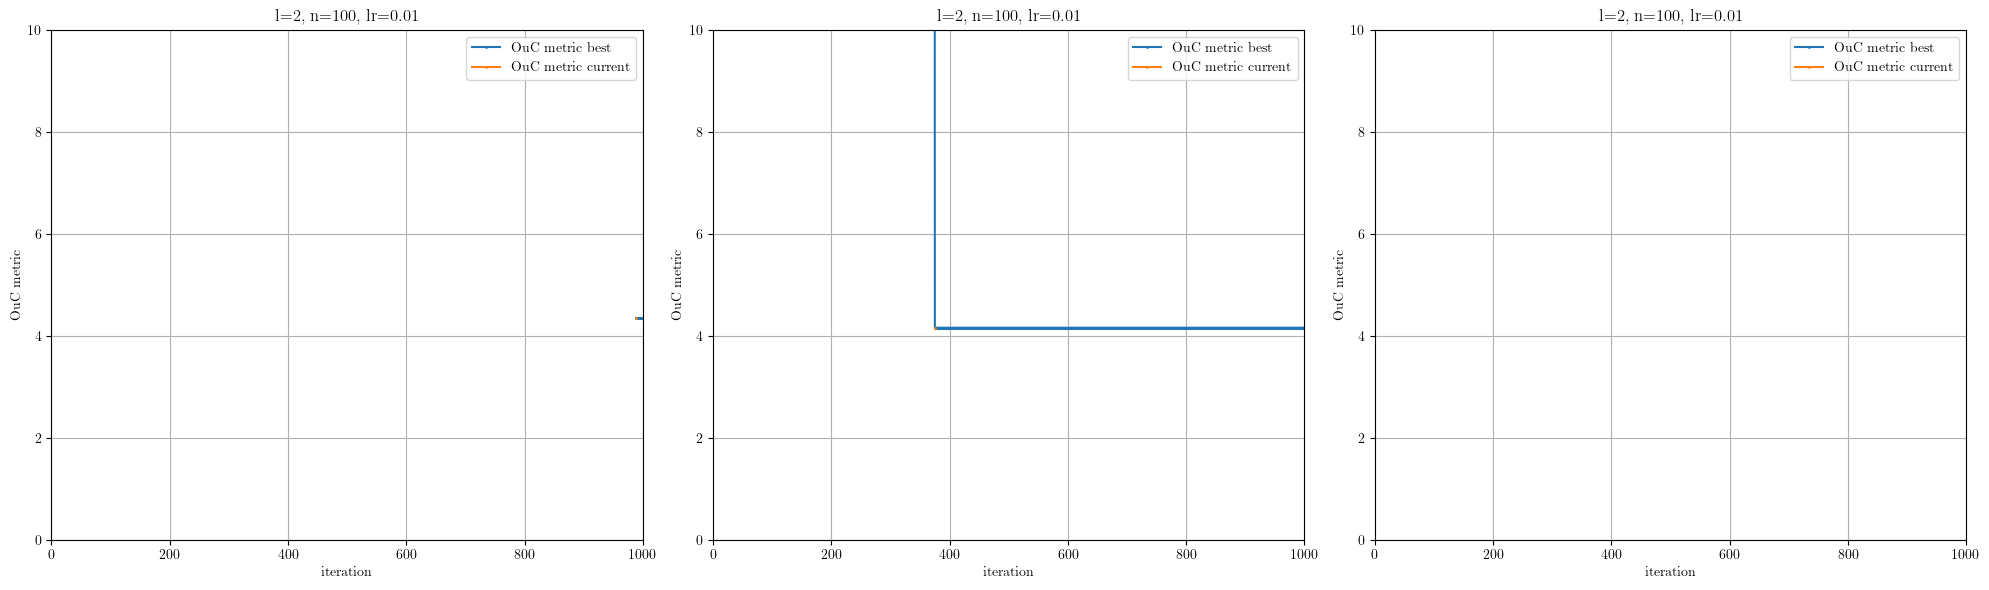

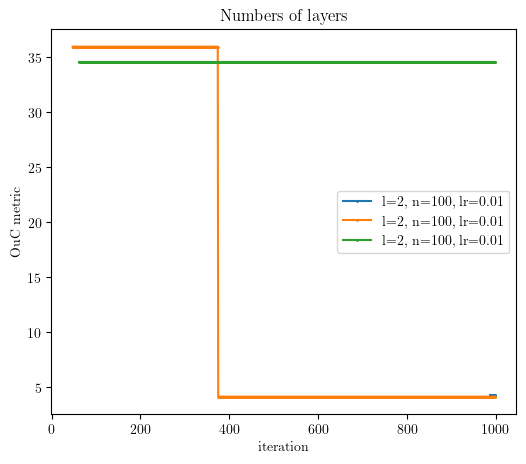

In [26]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 10.686155 MSE solution: 1.3749126625903827 ratio: 0.009 time: 232.92547607421875
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.7018924 MSE solution: 0.061638896737737446 ratio: 0.036 time: 228.57705402374268
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 5.663629 MSE solution: 0.19793167679355847 ratio: 0.011 time: 220.69820833206177


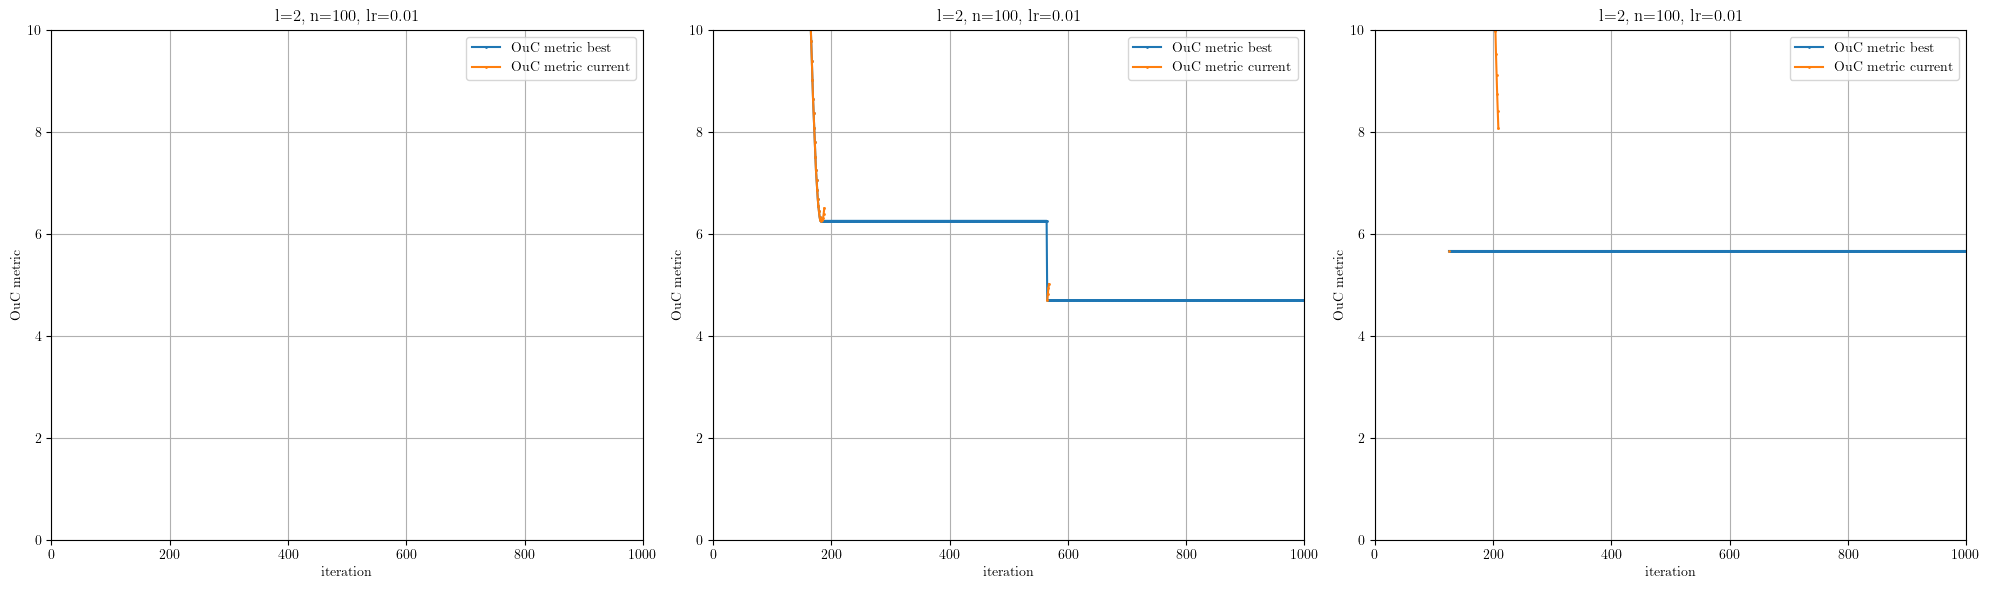

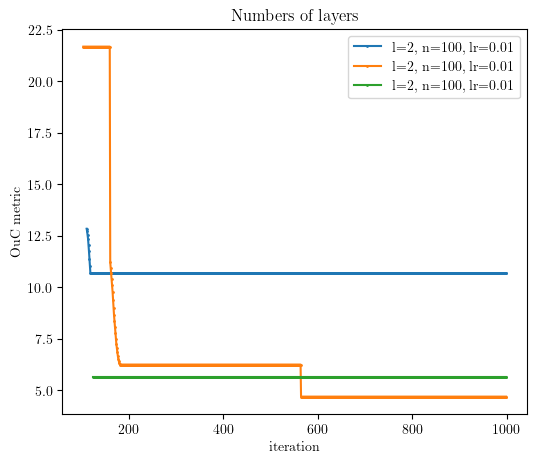

In [27]:
WEIGTHING = 1
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.8000302 MSE solution: 0.004685984704541505 ratio: 0.028 time: 221.24251866340637
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 11.663918 MSE solution: 1.8541833511547143 ratio: 0.004 time: 234.11486148834229
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.5693135 MSE solution: 0.047667014953469554 ratio: 0.021 time: 236.17444157600403


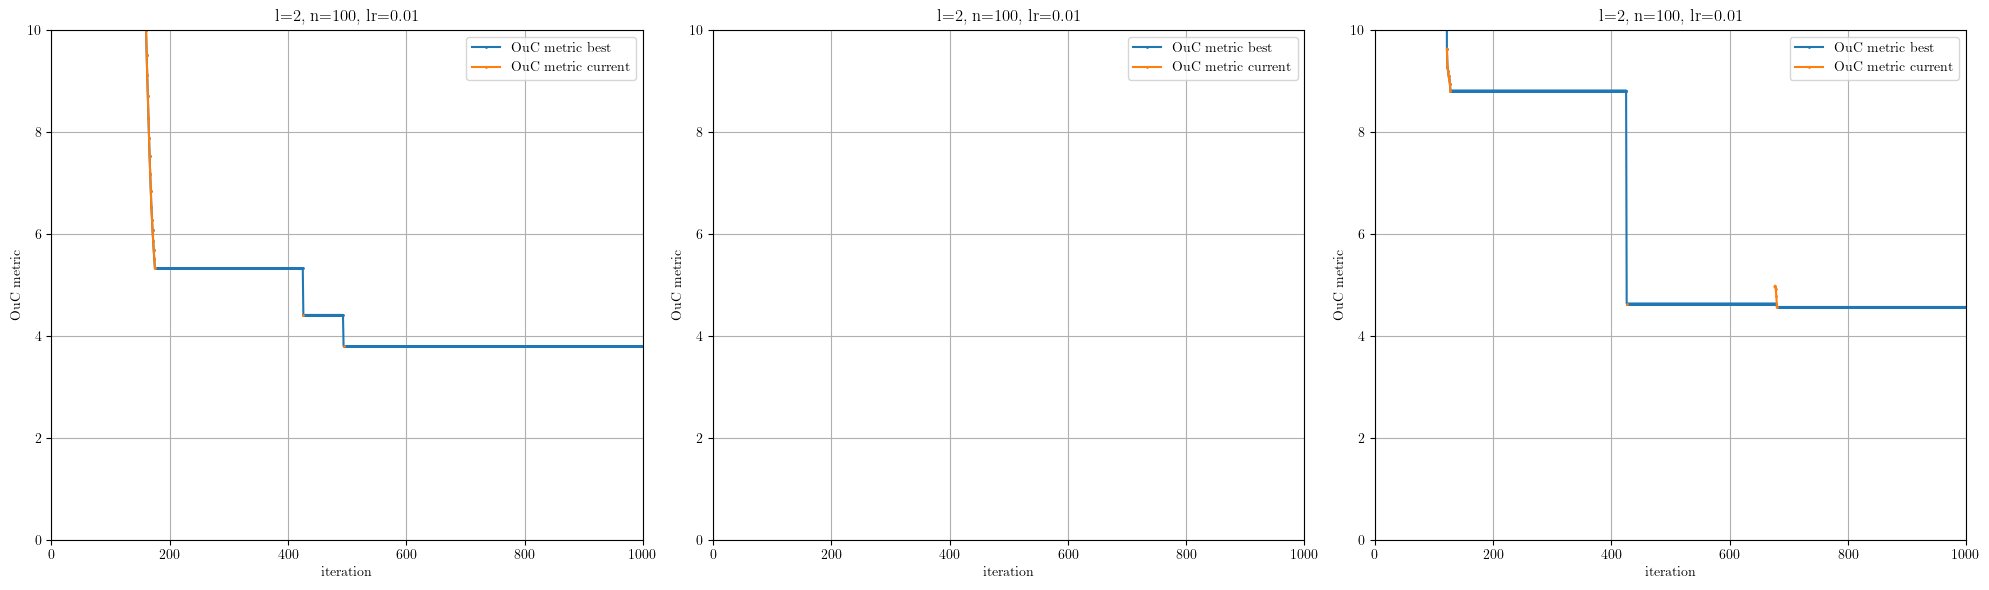

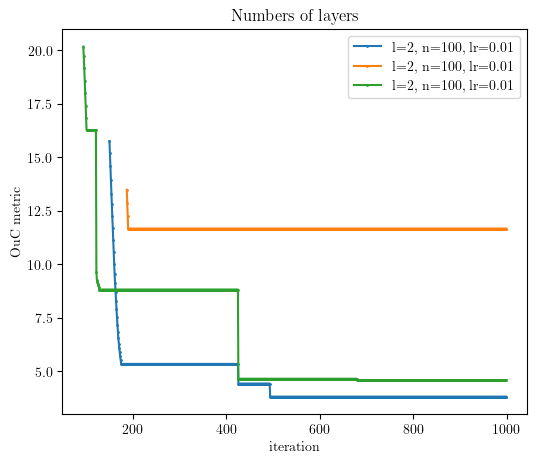

In [28]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.123417 MSE solution: 0.030670136448806812 ratio: 0.008 time: 217.3590841293335
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.7835379 MSE solution: 0.0035342523088371263 ratio: 0.027 time: 218.56874537467957
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.2473154 MSE solution: 0.02468266146592425 ratio: 0.002 time: 215.41410279273987


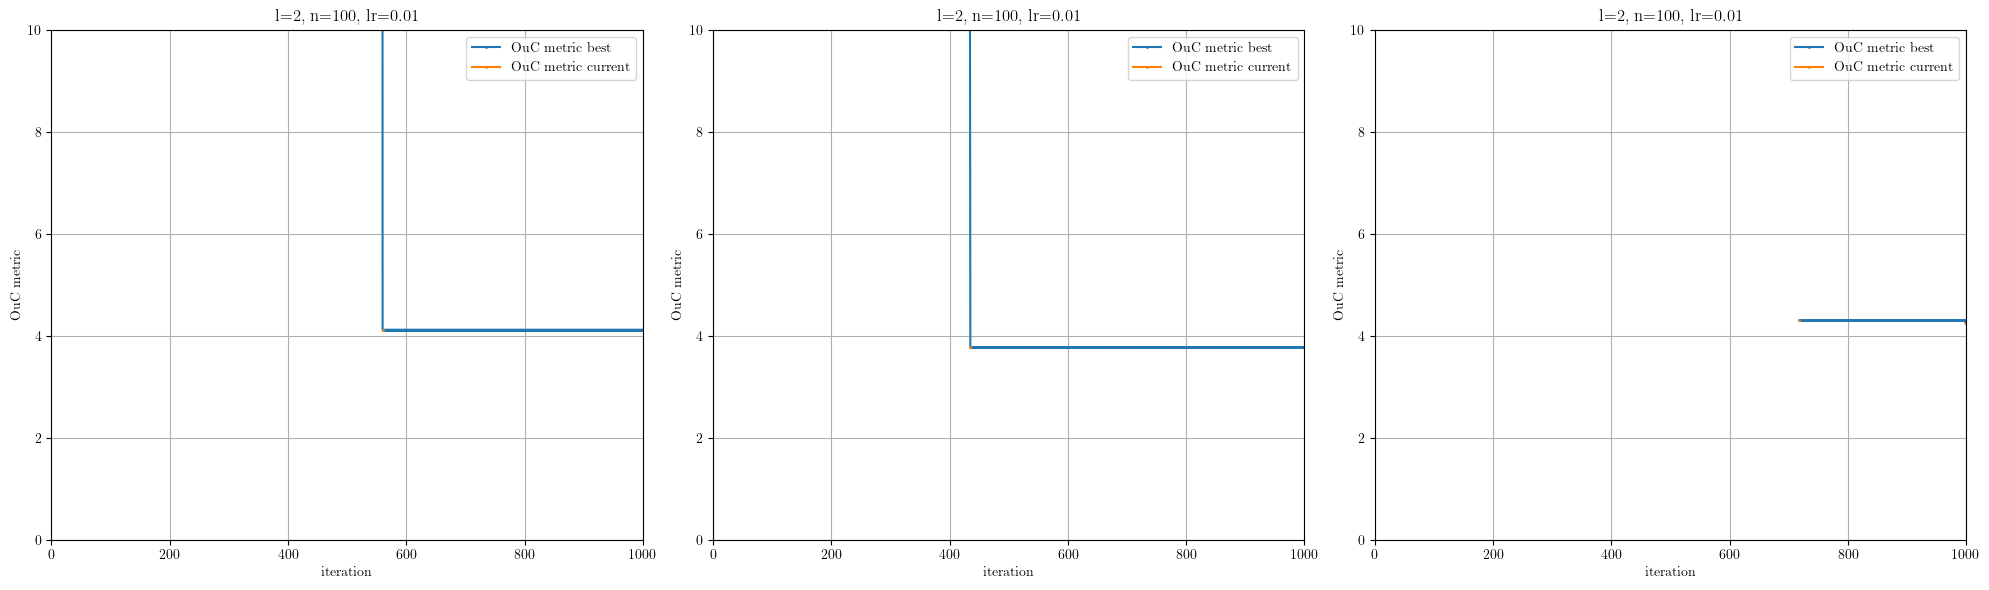

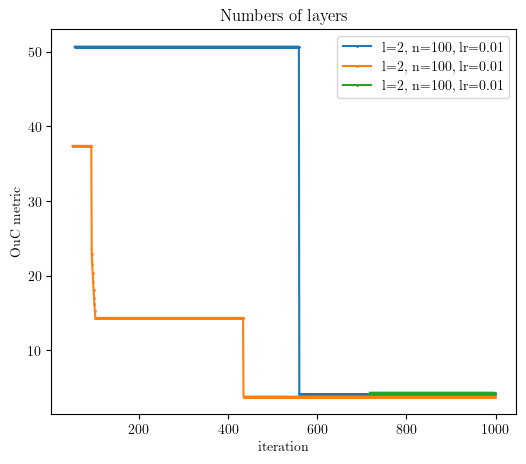

In [29]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.05282 MSE solution: 0.025480450239693777 ratio: 0.017 time: 219.37250185012817
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.7245686 MSE solution: 0.0025715734436122096 ratio: 0.007 time: 211.51394844055176
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 5.4905844 MSE solution: 0.14837906172712376 ratio: 0.04 time: 207.9526720046997


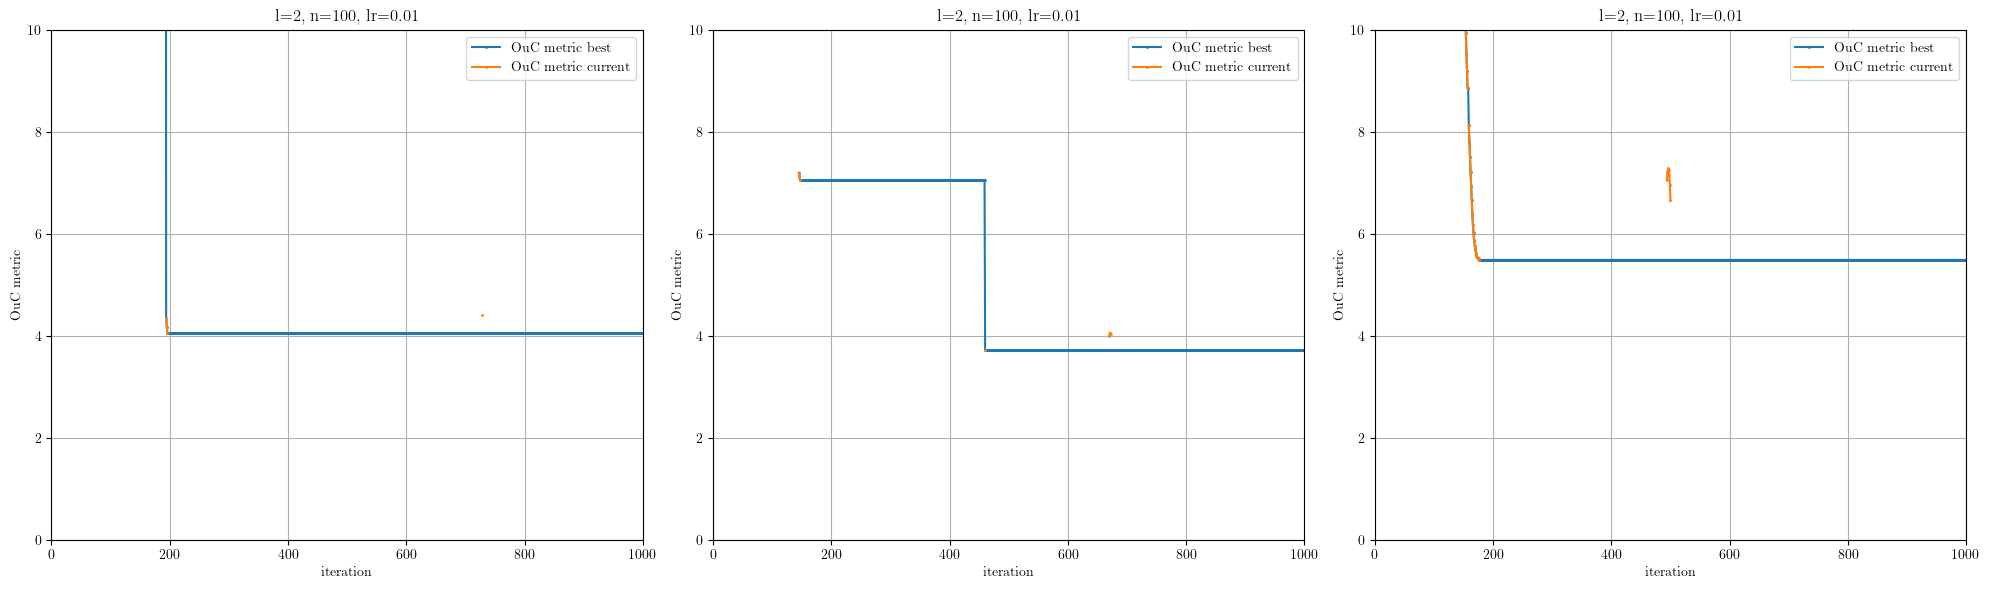

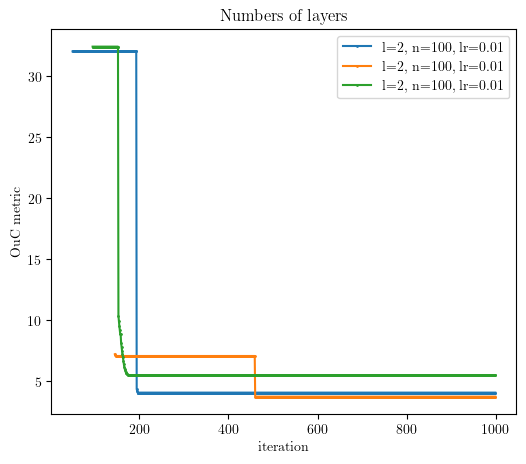

In [30]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 3.7214652513223725 ratio: 0.0 time: 203.27581691741943
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.411197 MSE solution: 0.05531507313694998 ratio: 0.023 time: 200.1020245552063
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 2.4619475993905486 ratio: 0.0 time: 199.14895176887512


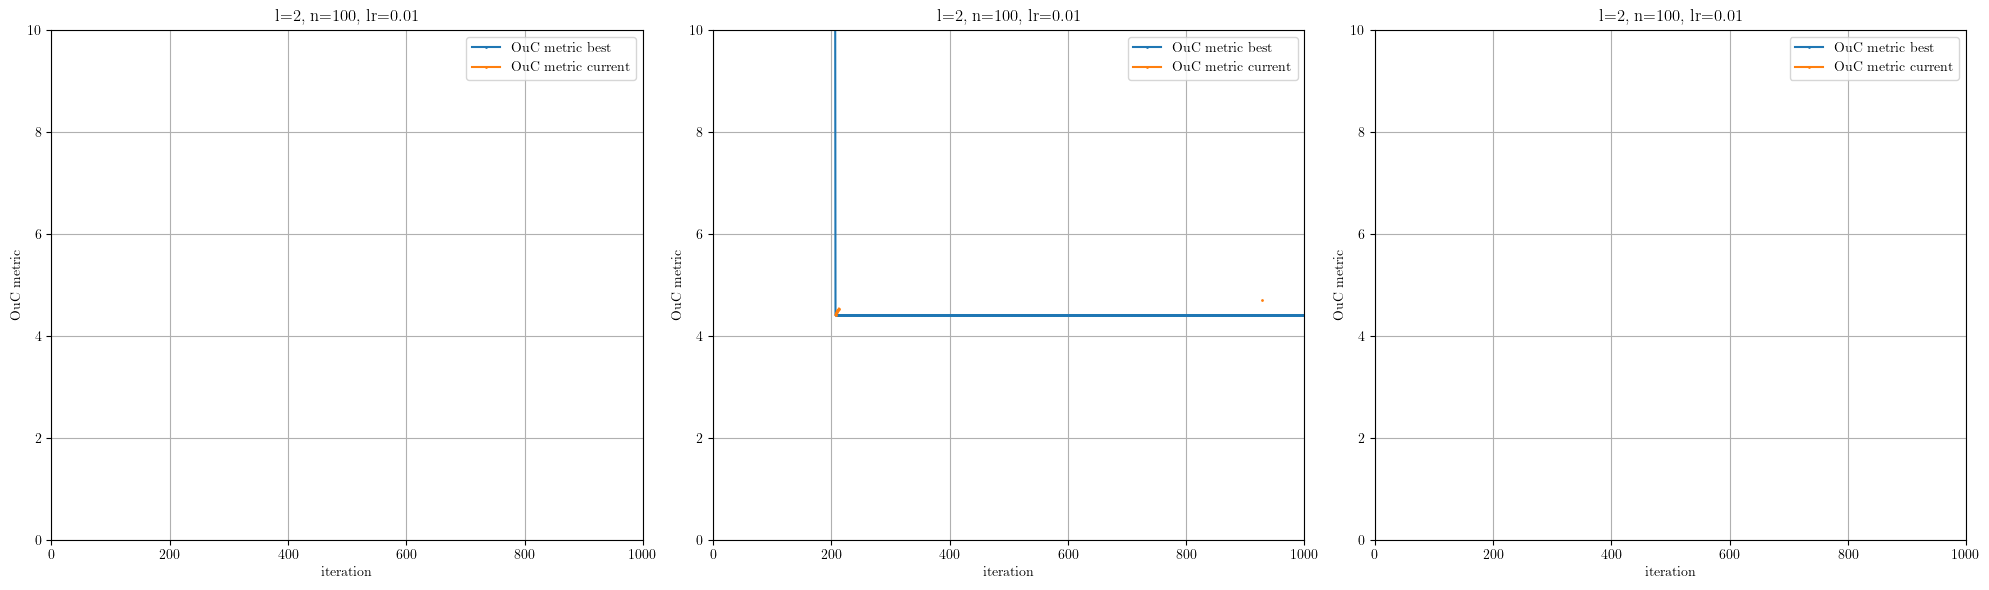

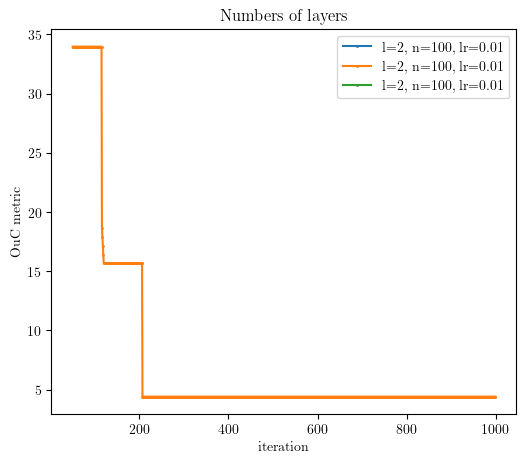

In [31]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 32.746613 MSE solution: 11.01029778173384 ratio: 0.011 time: 199.61223554611206
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.411334 MSE solution: 0.03506674869588078 ratio: 0.001 time: 197.31363916397095
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.328371 MSE solution: 0.05046839182841847 ratio: 0.005 time: 201.6838948726654


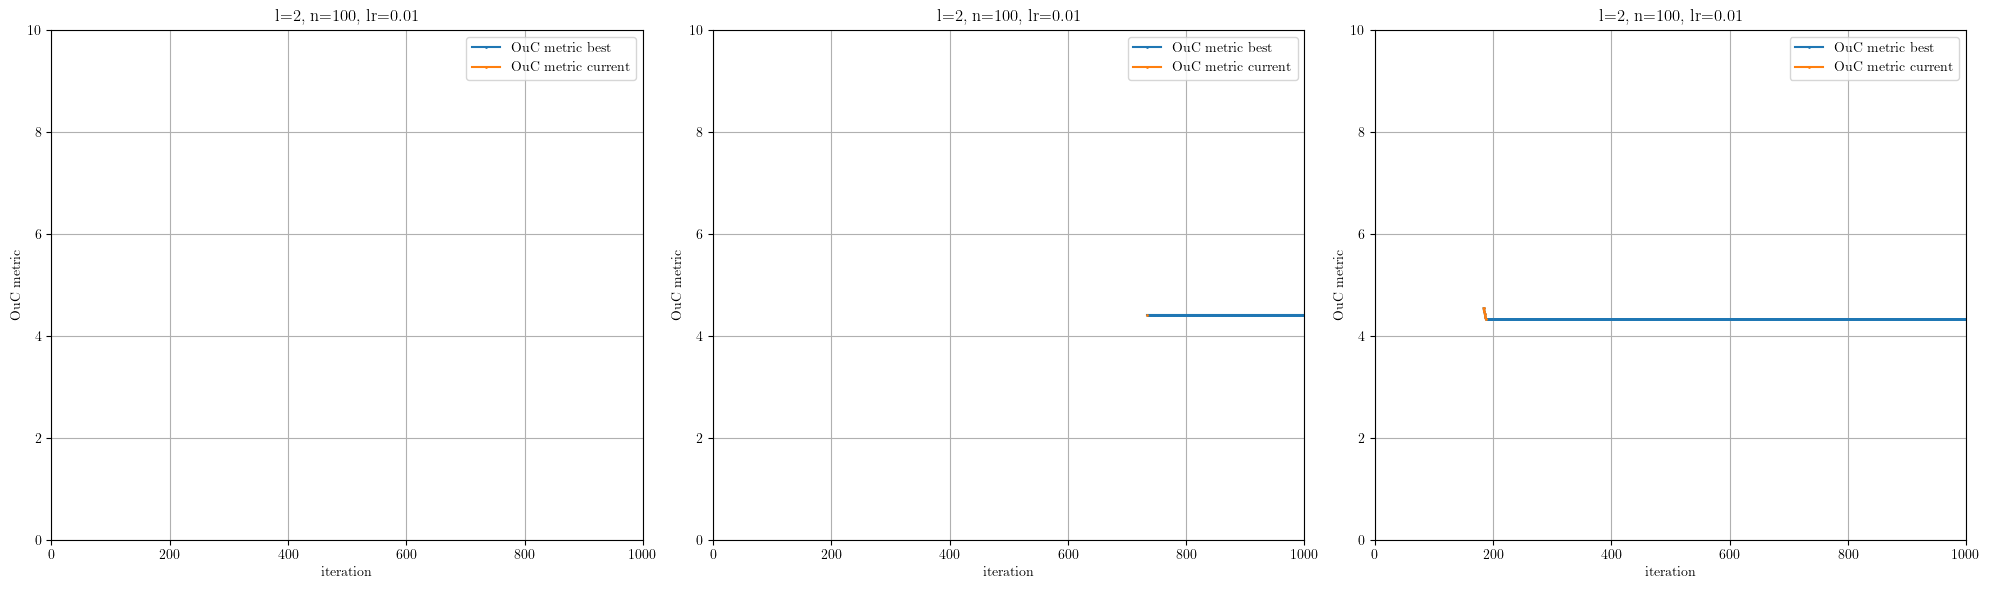

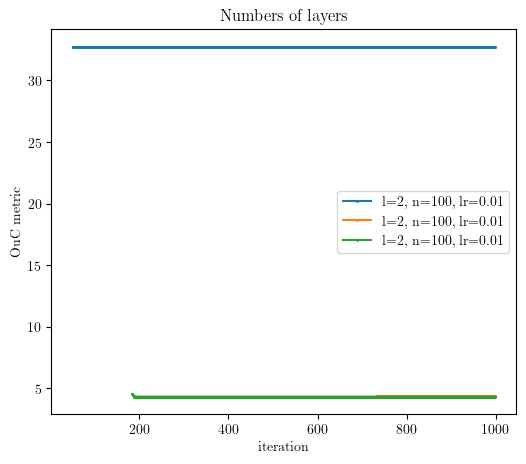

In [32]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.142909 MSE solution: 0.029515418970213075 ratio: 0.027 time: 199.1783058643341
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.8201904 MSE solution: 0.010782421198117634 ratio: 0.022 time: 199.04648542404175
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.6583788 MSE solution: 0.0023753751465700143 ratio: 0.002 time: 199.3856430053711


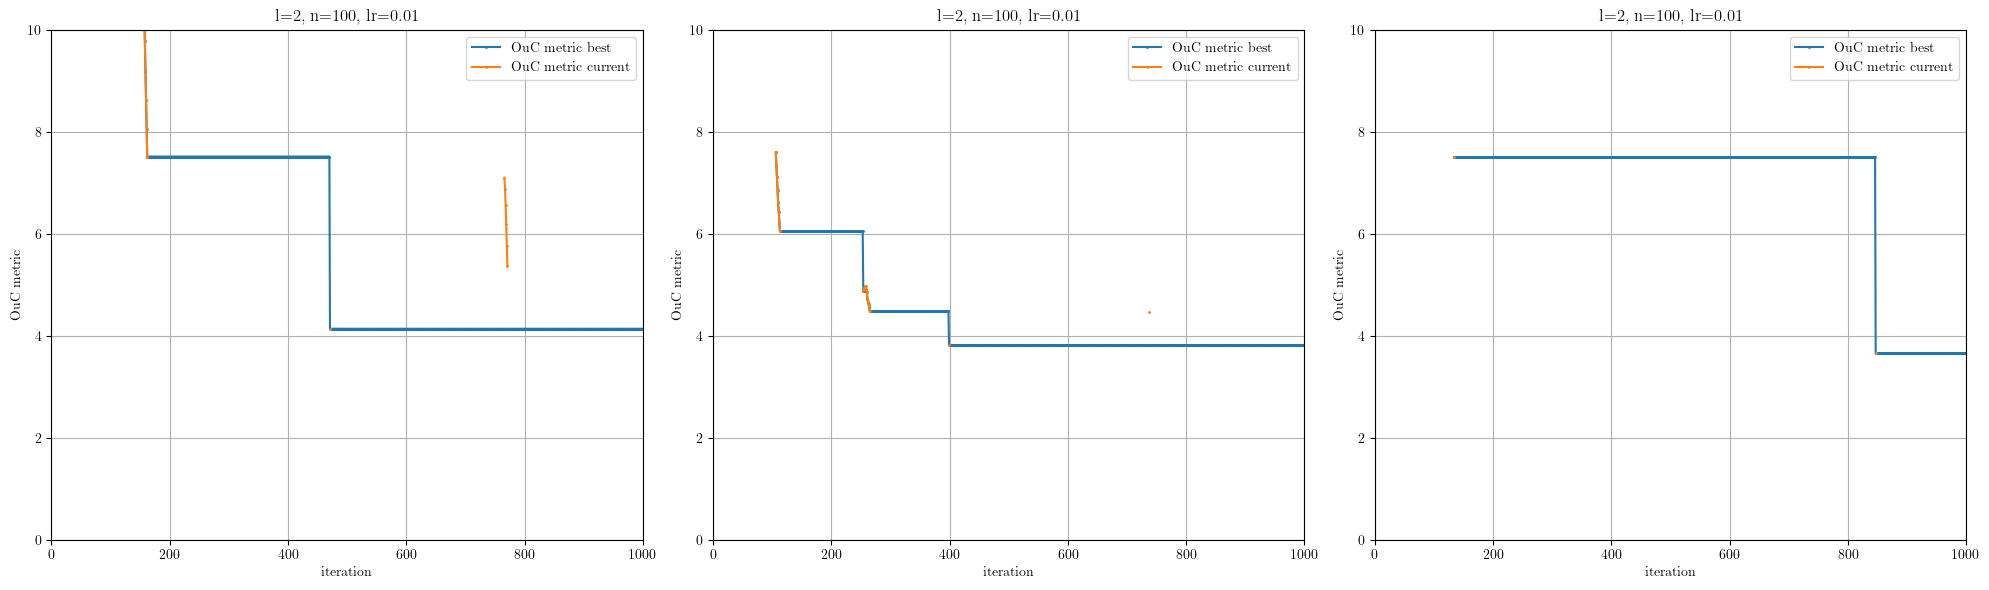

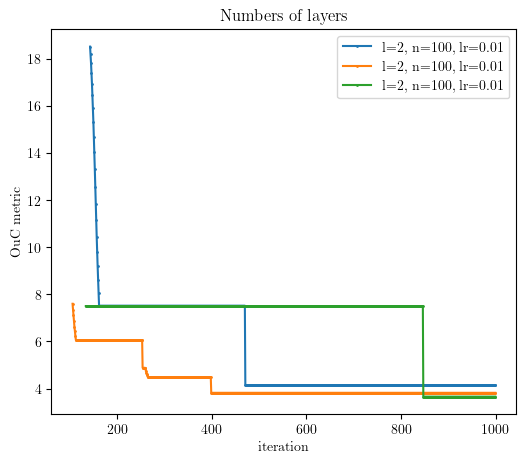

In [33]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 3.1110811137515846 ratio: 0.0 time: 196.76791524887085
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.610738 MSE solution: 0.06899432773840593 ratio: 0.007 time: 197.71512413024902
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.8133557 MSE solution: 0.013656845768233367 ratio: 0.009 time: 197.62653279304504


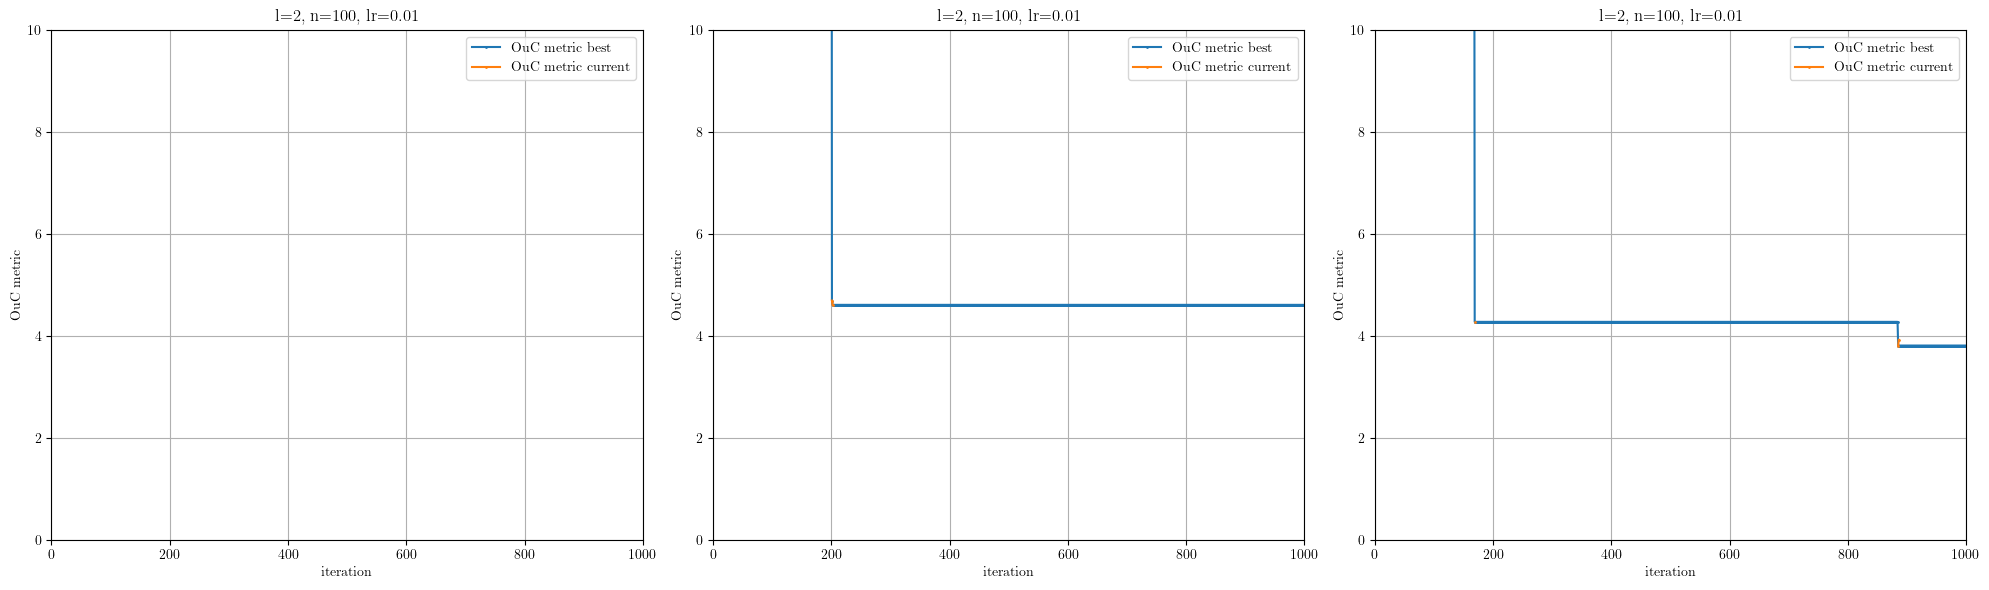

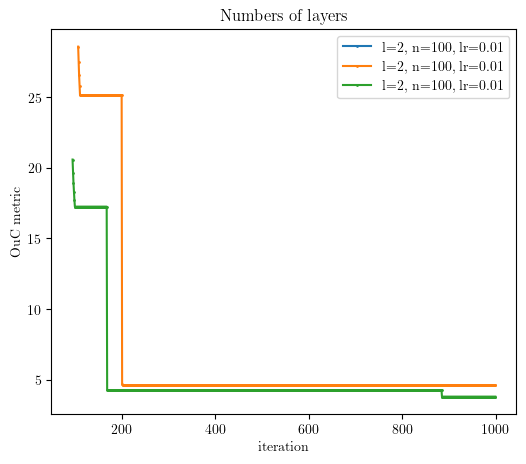

In [34]:
WEIGTHING = 2
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.9885428 MSE solution: 0.01233810757536404 ratio: 0.01 time: 197.0046648979187
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.352958 MSE solution: 0.03377104672955938 ratio: 0.021 time: 198.1626033782959
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.8473473 MSE solution: 0.0055842457175512865 ratio: 0.004 time: 200.79646944999695


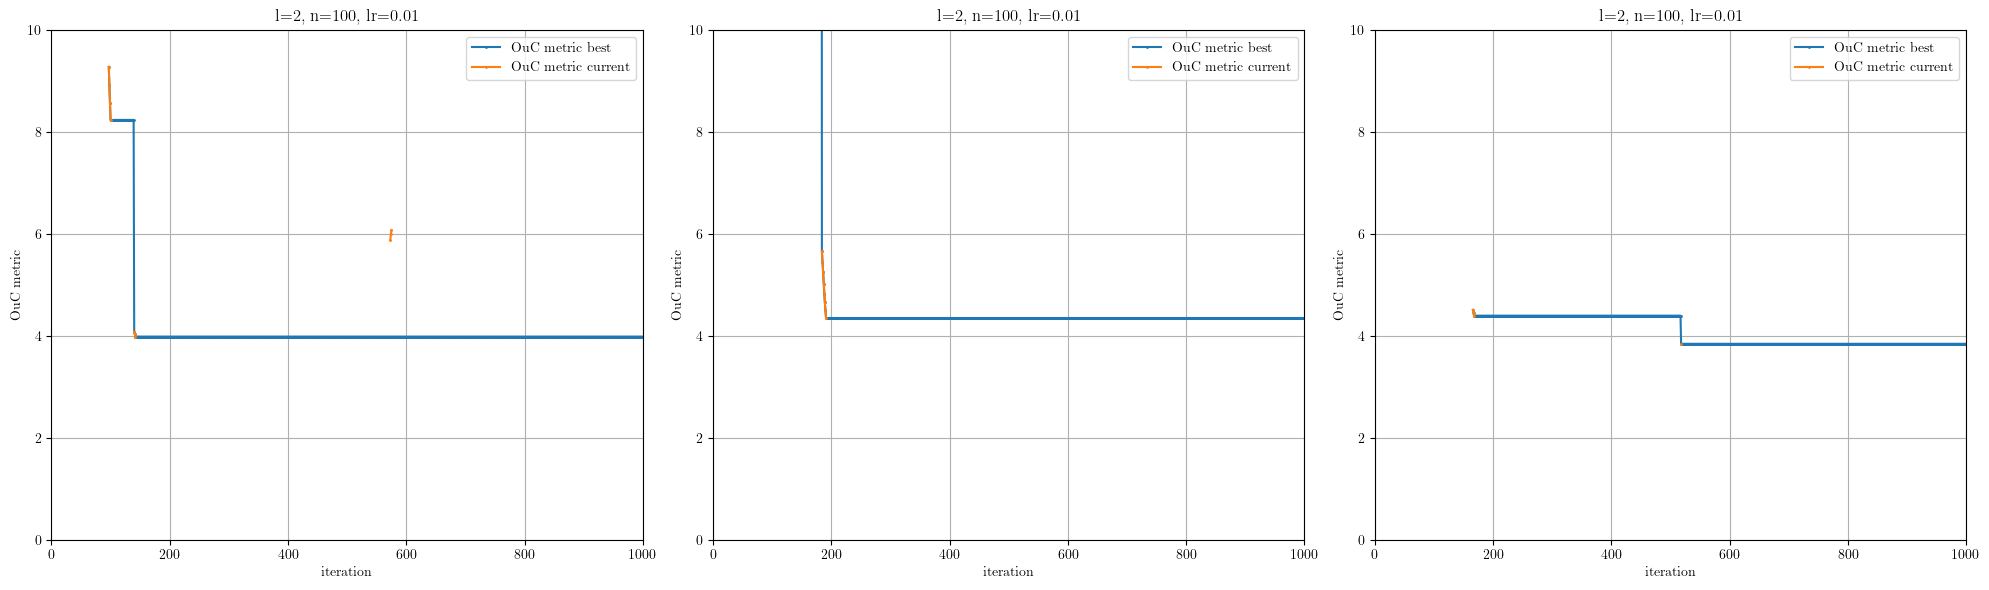

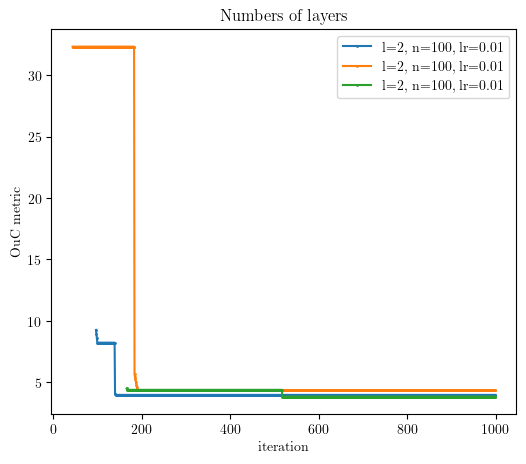

In [35]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.626088 MSE solution: 0.07166779266924651 ratio: 0.002 time: 197.5679006576538
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 33.48085 MSE solution: 12.668906820407734 ratio: 0.01 time: 198.76191568374634
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.112716 MSE solution: 0.018825477526683124 ratio: 0.027 time: 198.17205023765564


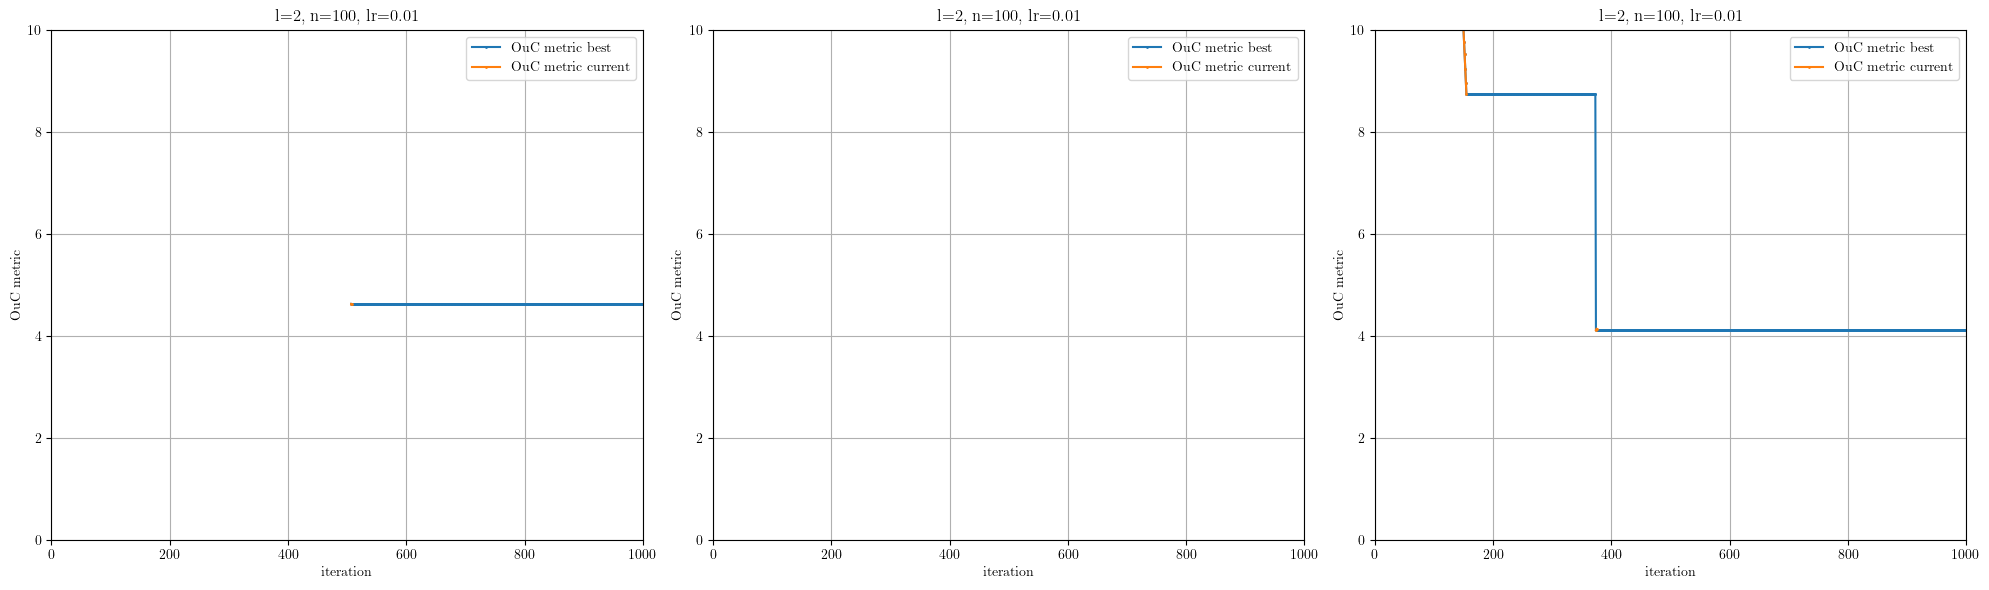

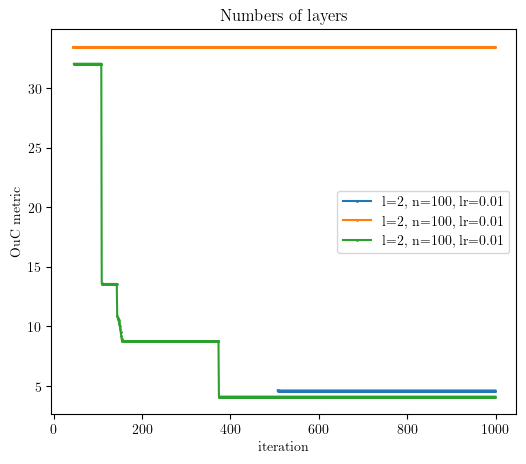

In [36]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.0550137 MSE solution: 0.02575319463497812 ratio: 0.011 time: 198.05353617668152
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.9426231 MSE solution: 0.013738425035018348 ratio: 0.03 time: 198.18059706687927
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 4.05149158303286 ratio: 0.0 time: 197.37692785263062


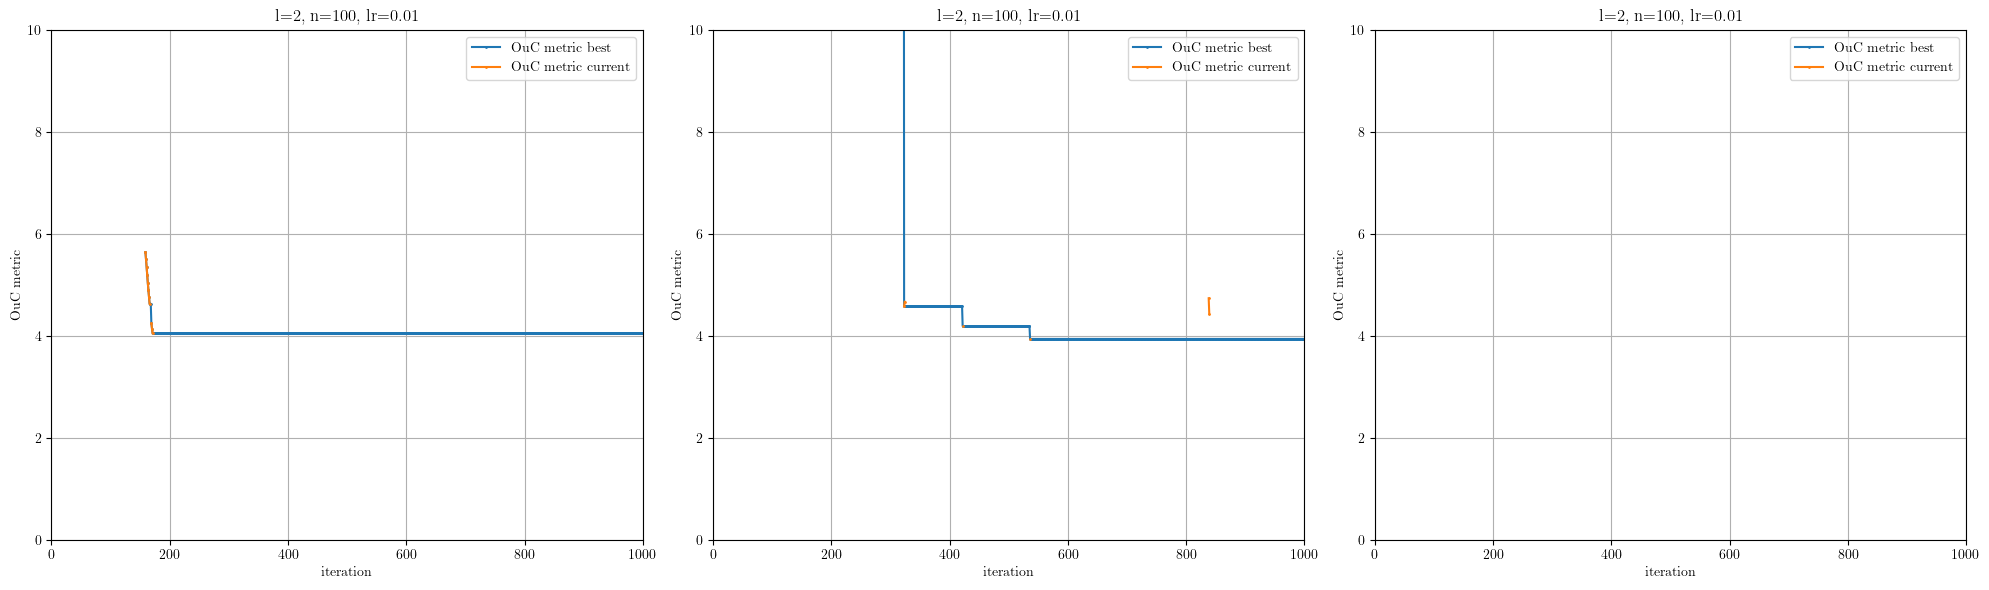

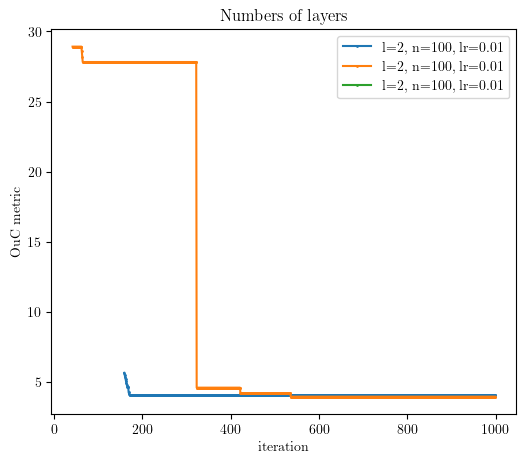

In [37]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.9718018 MSE solution: 0.11248491629418172 ratio: 0.016 time: 199.65349459648132
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 2.9594714471245993 ratio: 0.0 time: 202.23089480400085
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 8.12852 MSE solution: 0.7476002908608943 ratio: 0.012 time: 199.41592574119568


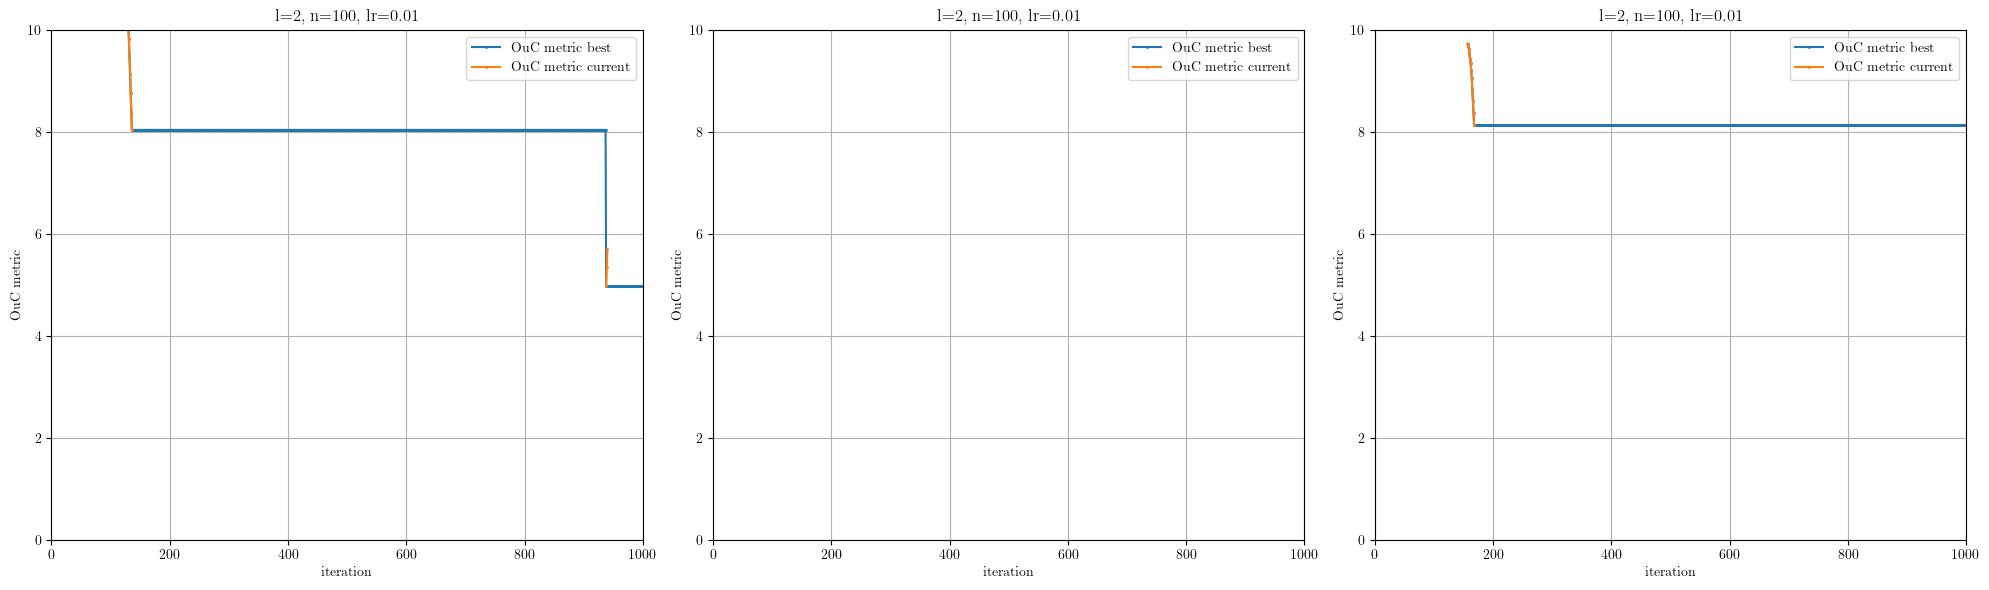

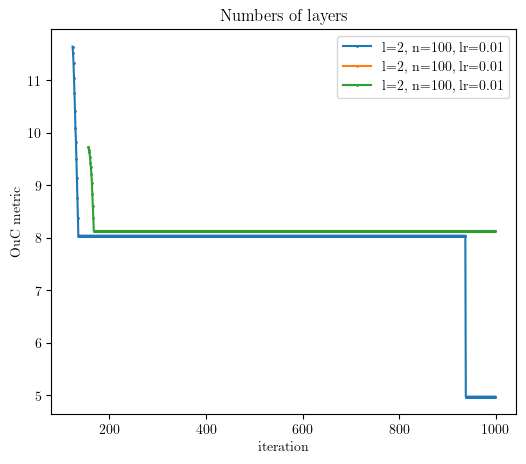

In [38]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 36.76218 MSE solution: 14.846420157612128 ratio: 0.003 time: 199.00587964057922
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 3.797270121810316 ratio: 0.0 time: 197.97609972953796
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 34.050056 MSE solution: 12.710607538322364 ratio: 0.007 time: 199.49431538581848


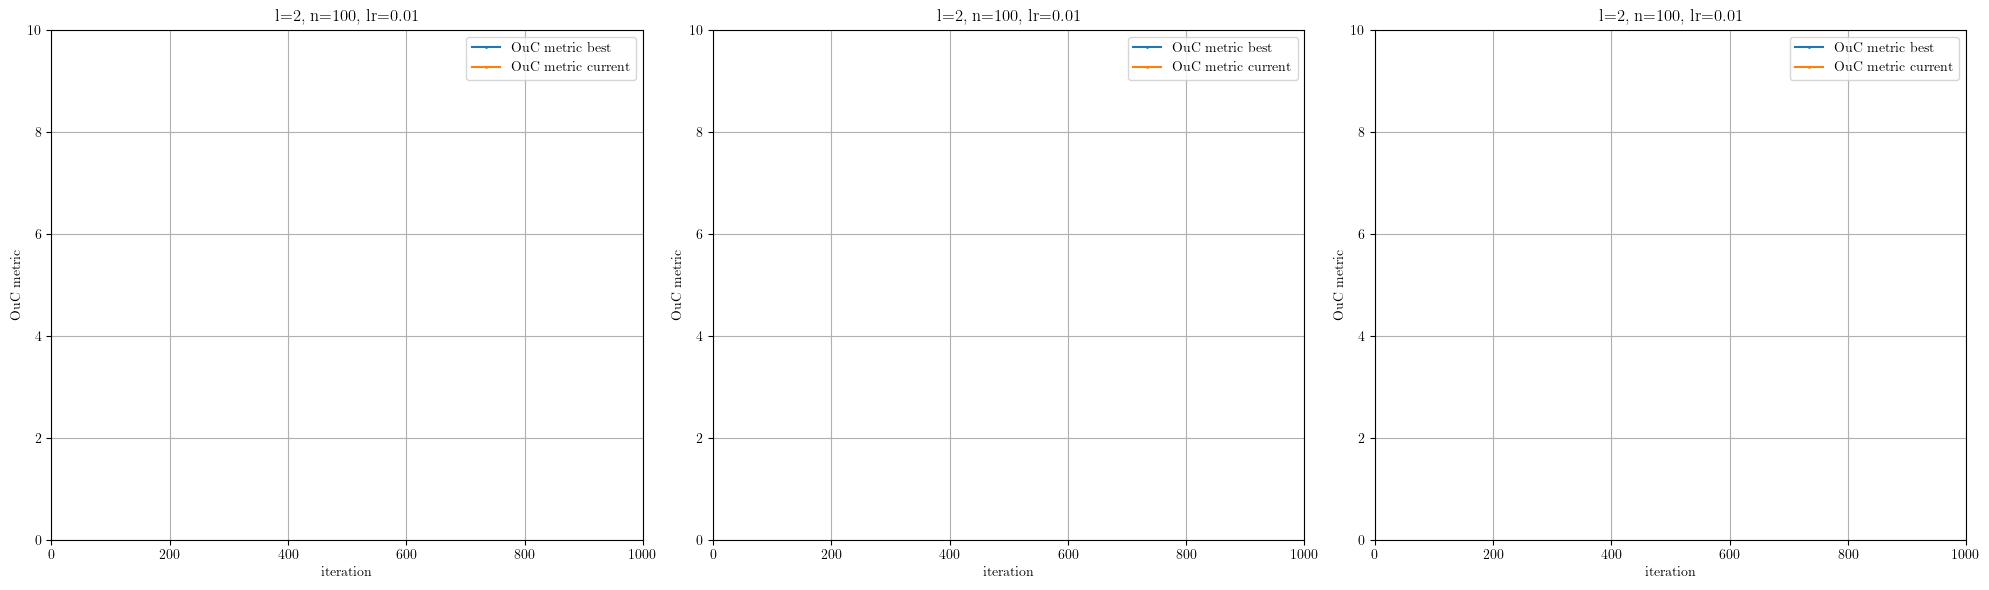

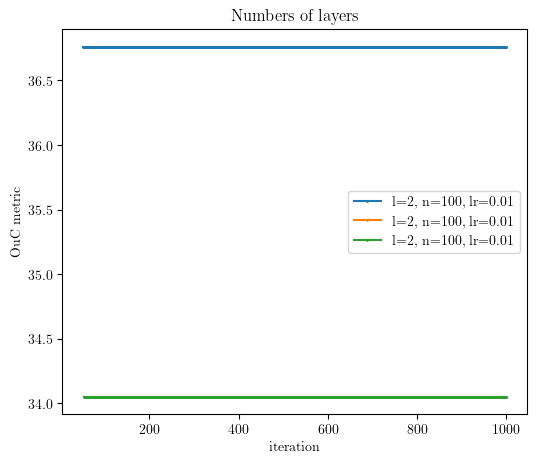

In [39]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 16.281723 MSE solution: 3.560832640589847 ratio: 0.016 time: 201.84165239334106
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.9203184 MSE solution: 0.013345676647241456 ratio: 0.02 time: 200.94221568107605
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 7.352229 MSE solution: 0.6173195482687498 ratio: 0.016 time: 198.86529517173767


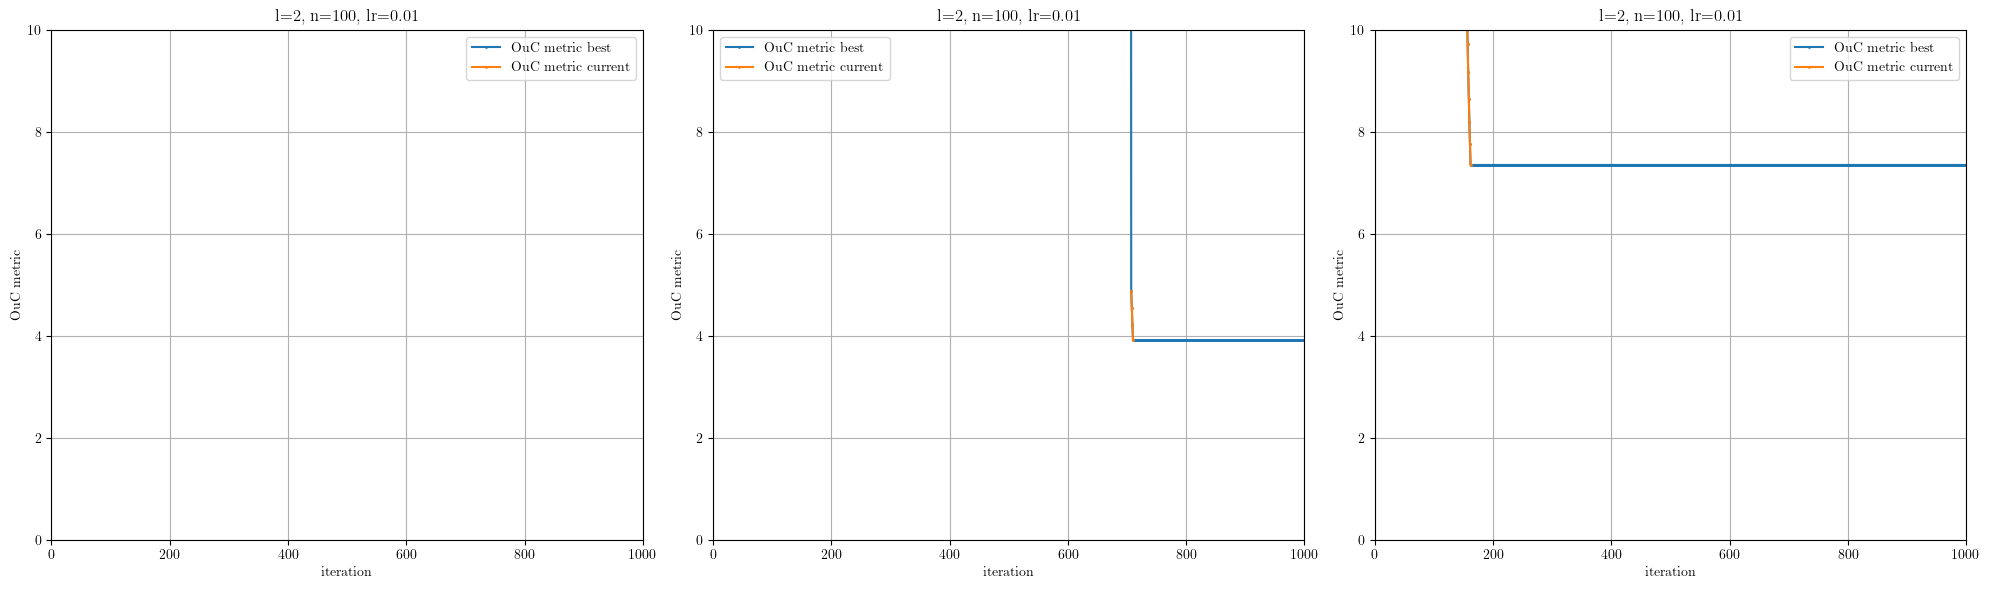

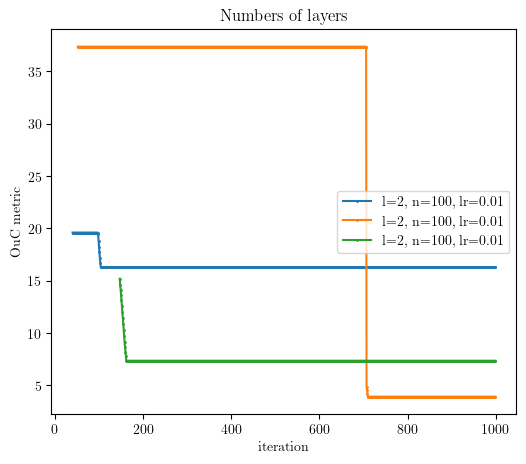

In [40]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 6.362865 MSE solution: 0.33541308486239757 ratio: 0.016 time: 199.52700662612915
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 3.2171040052506457 ratio: 0.0 time: 197.80282545089722
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 5.180129 MSE solution: 0.11023064888743273 ratio: 0.018 time: 199.4069902896881


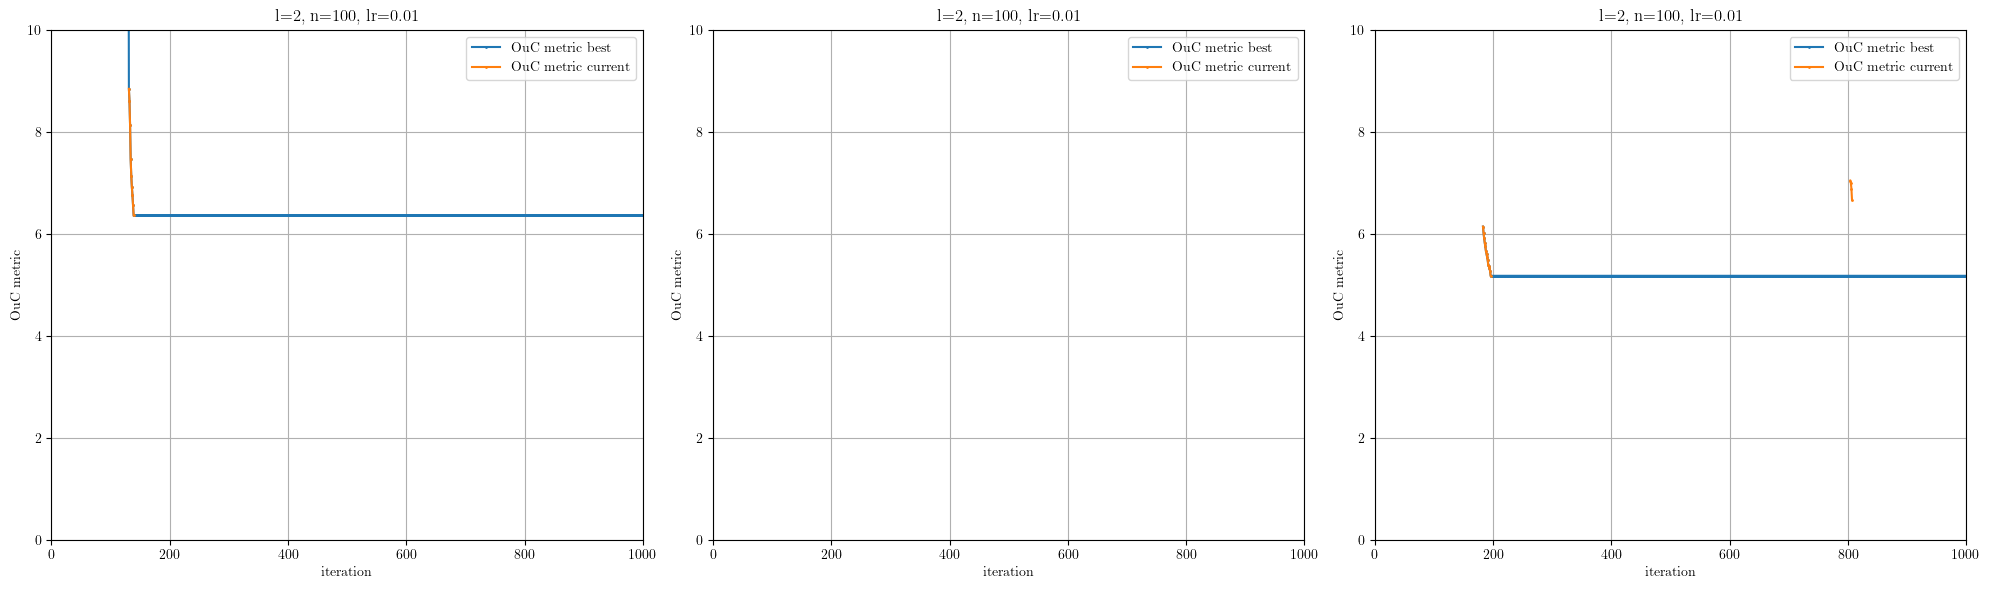

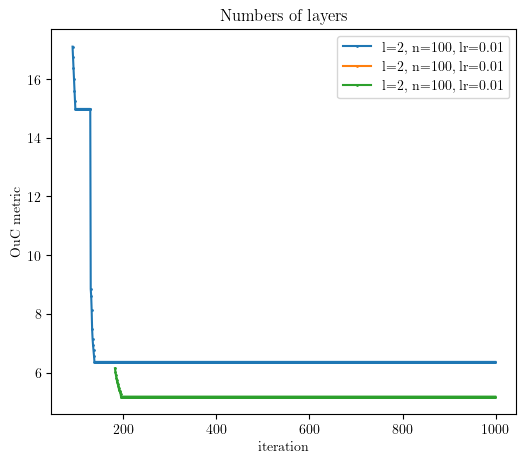

In [41]:
WEIGTHING = 4
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 7.6745224 MSE solution: 0.5580525890208895 ratio: 0.009 time: 223.65120697021484
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.520866 MSE solution: 0.049742636589605115 ratio: 0.013 time: 221.85070991516113
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.0371857 MSE solution: 0.024849370524433183 ratio: 0.011 time: 217.5221676826477


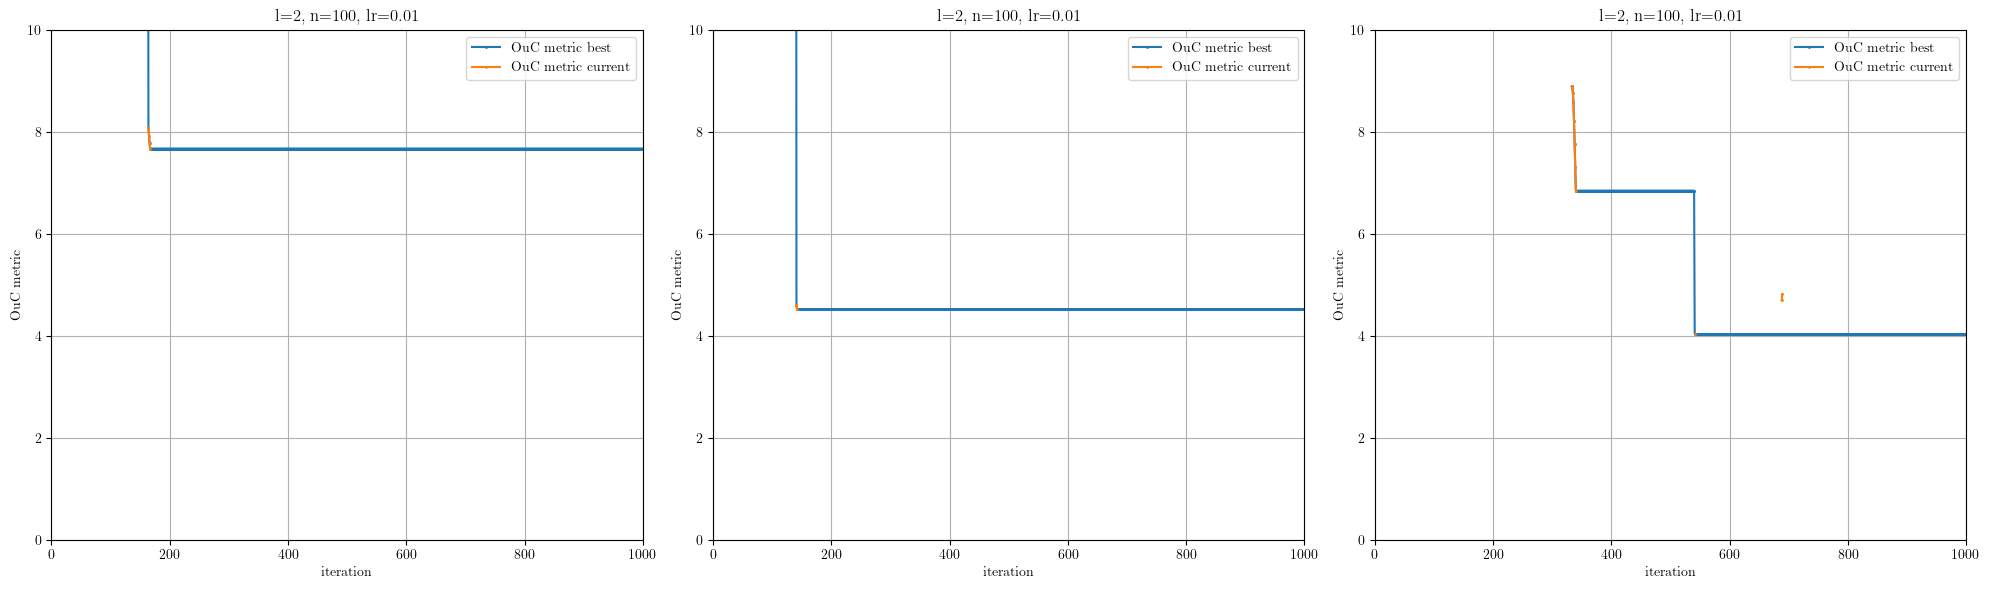

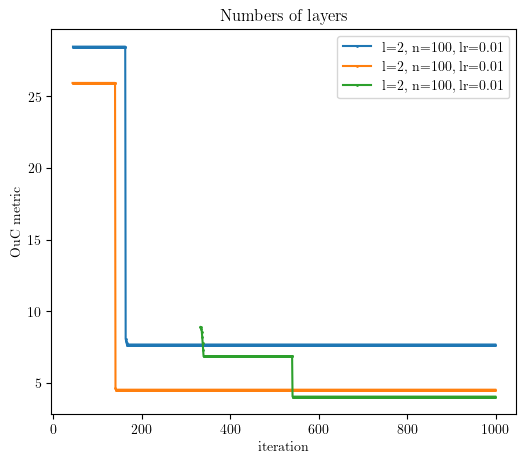

In [42]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 5.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.1459913 MSE solution: 0.02349269646515514 ratio: 0.009 time: 221.02705883979797
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 2.948036914899541 ratio: 0.0 time: 213.15810585021973
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 6.518094 MSE solution: 0.31225532565800923 ratio: 0.005 time: 205.5279619693756


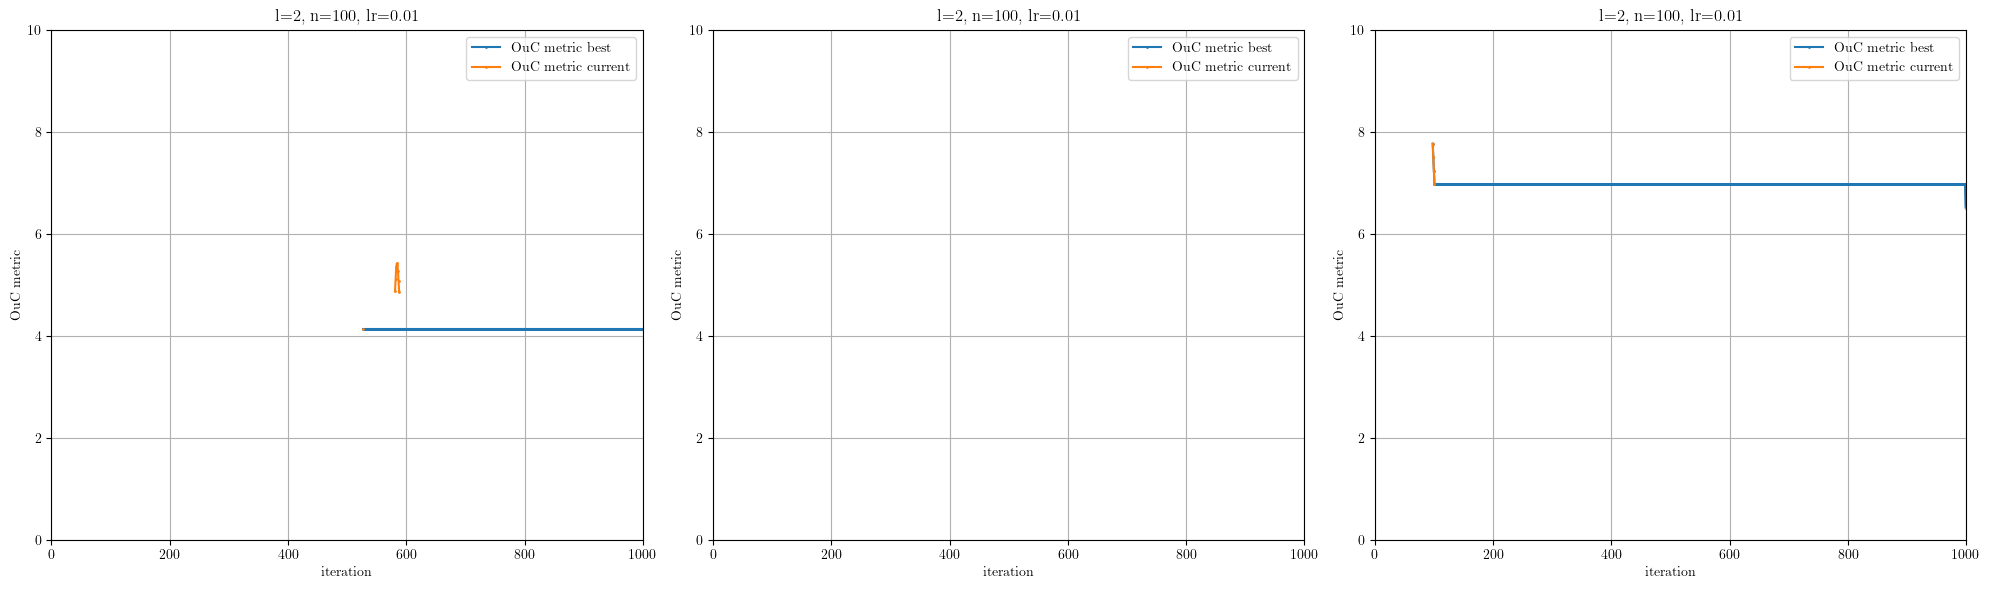

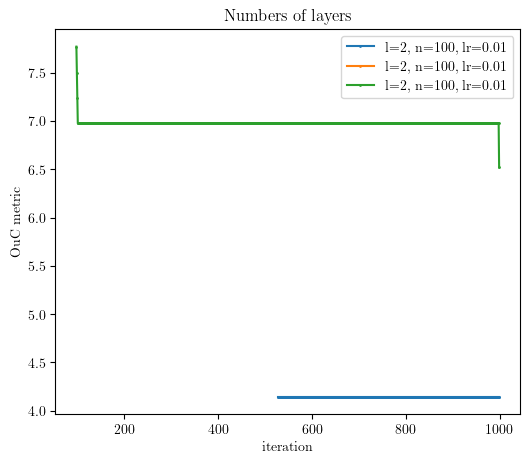

In [43]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 10.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.3635283 MSE solution: 0.04813004475701866 ratio: 0.004 time: 211.5833456516266
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 2.2100671019629012 ratio: 0.0 time: 202.55399870872498
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.9037688 MSE solution: 0.0165626568569773 ratio: 0.009 time: 202.88519144058228


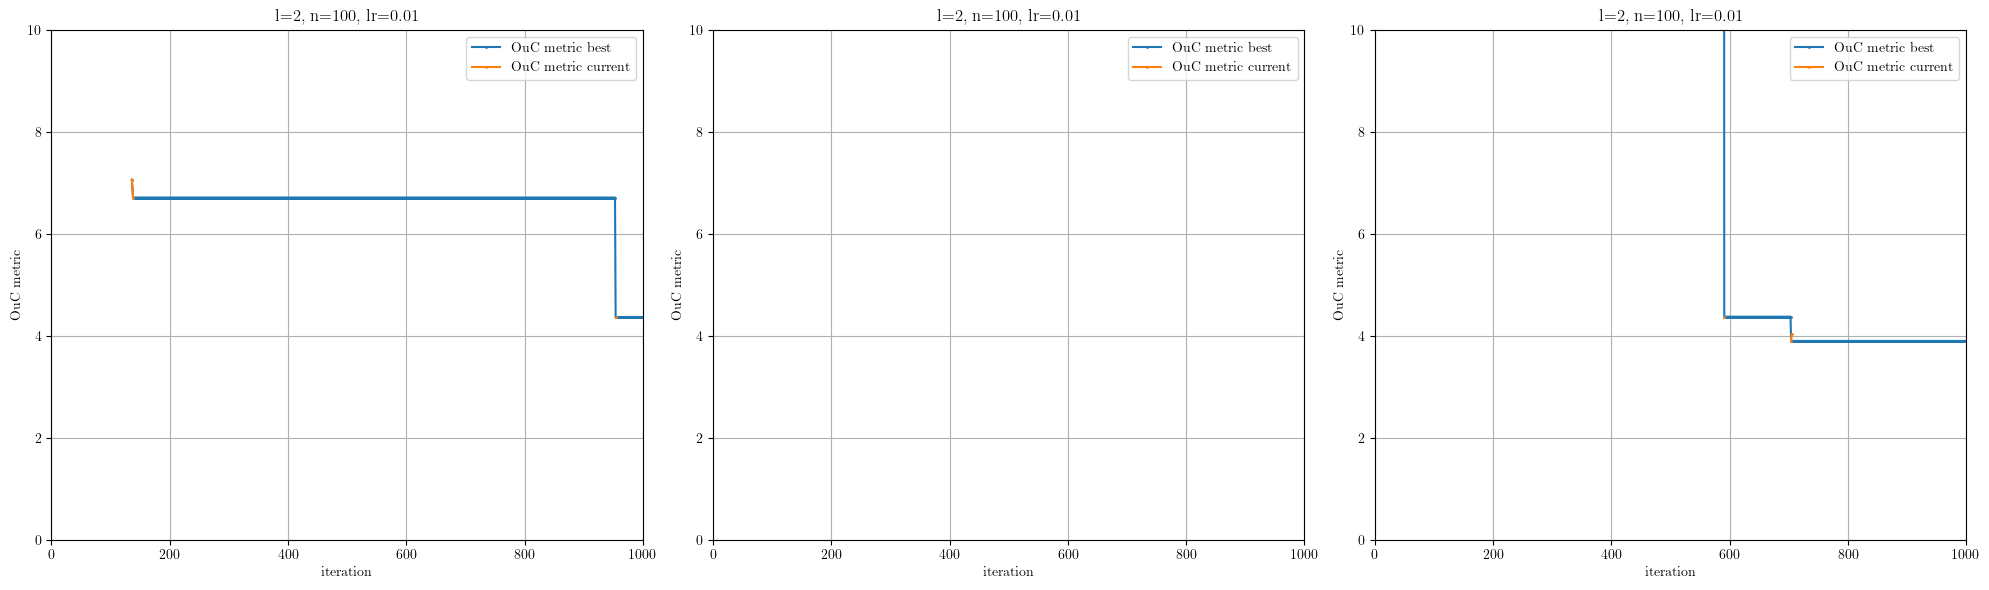

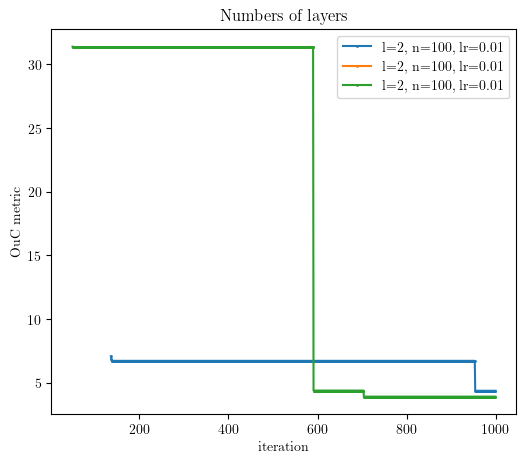

In [44]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 20.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.2388396 MSE solution: 0.02394209177344818 ratio: 0.001 time: 205.69401121139526
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.338315 MSE solution: 0.04654233946883246 ratio: 0.003 time: 207.4406862258911
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.097298 MSE solution: 0.016625041344098968 ratio: 0.001 time: 203.3153064250946


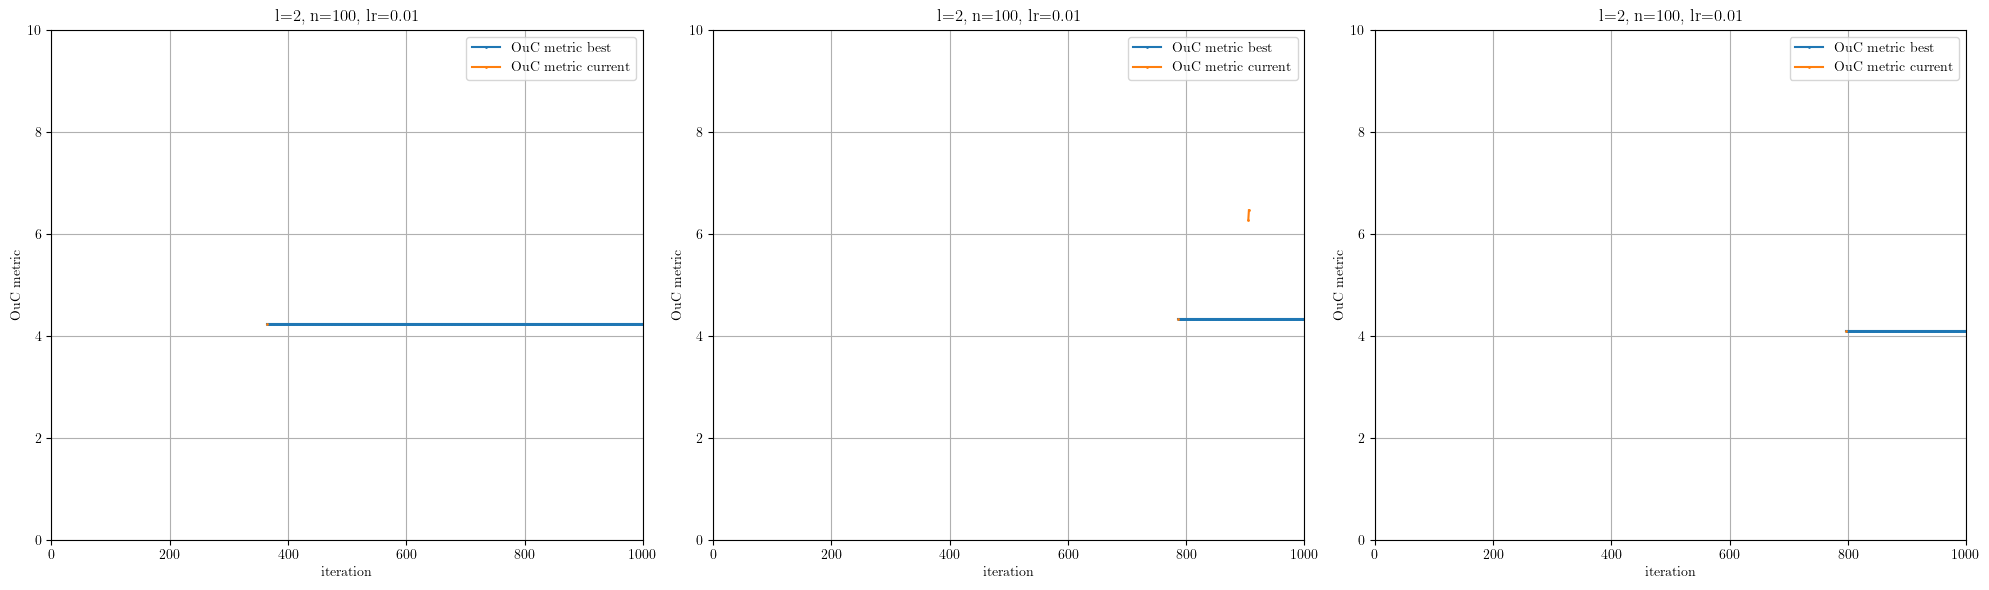

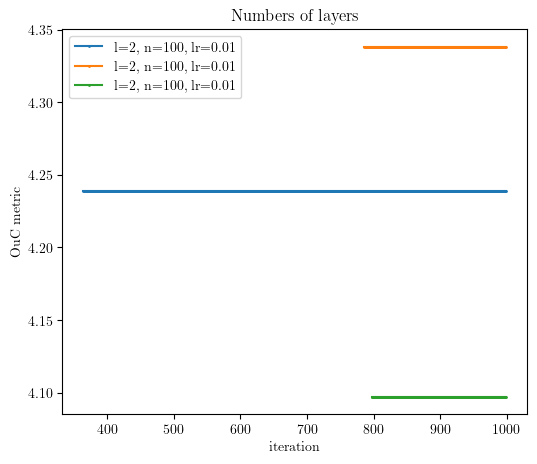

In [45]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 50.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: inf MSE solution: 2.6972146909150823 ratio: 0.0 time: 208.83210372924805
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 5.688713 MSE solution: 0.17804659076377194 ratio: 0.049 time: 205.74940133094788
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.5007813 MSE solution: 0.00010642777456144783 ratio: 0.013 time: 206.03938221931458


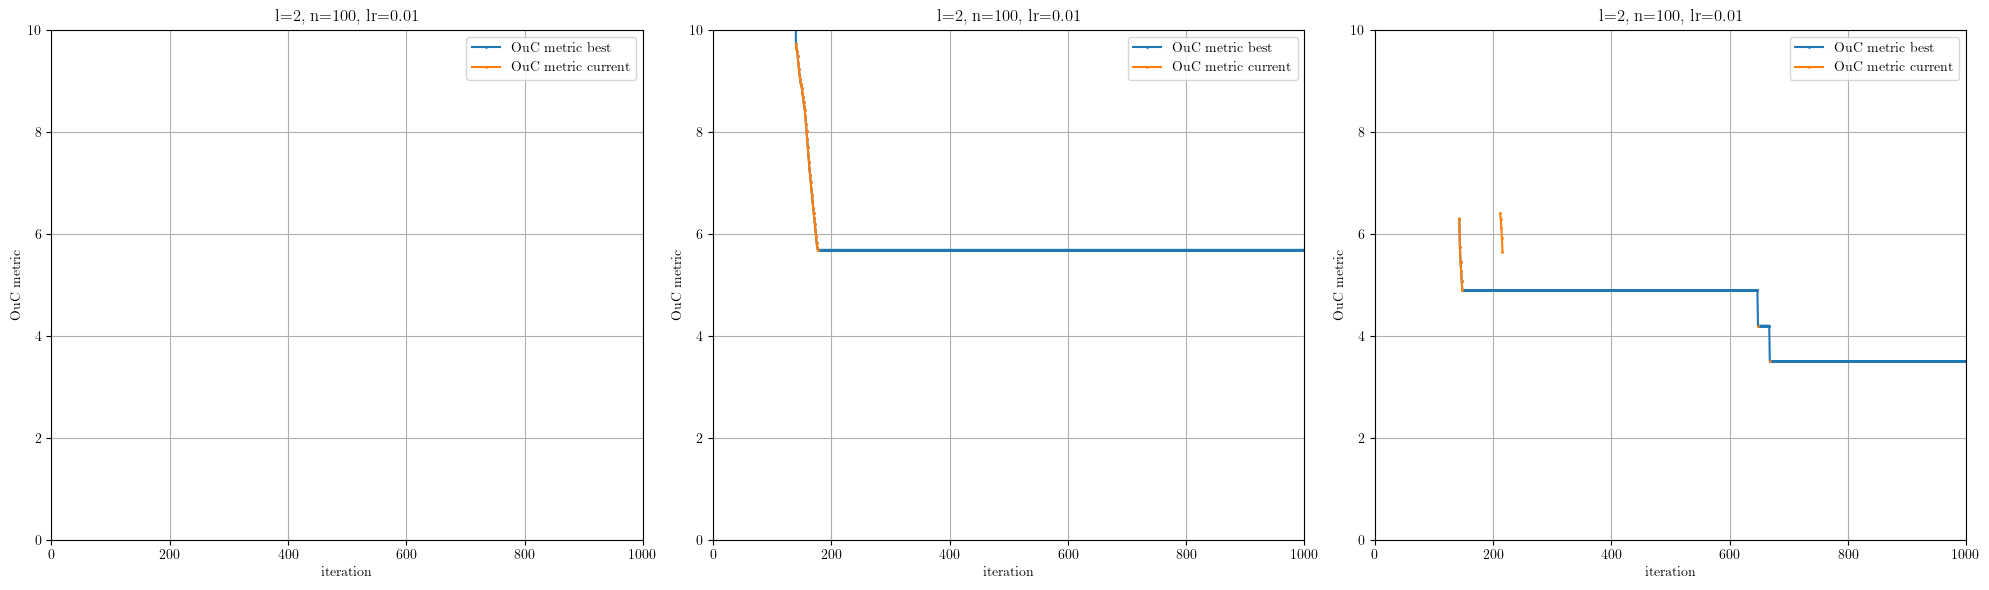

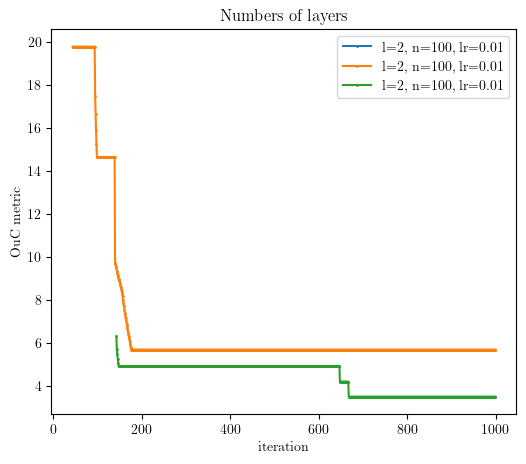

In [46]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 100.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.851611 MSE solution: 0.007548124117999815 ratio: 0.019 time: 210.87245106697083
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.999171 MSE solution: 0.011817546884499866 ratio: 0.011 time: 210.0002646446228
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 3.998604 MSE solution: 0.01597131087223703 ratio: 0.003 time: 202.6647937297821


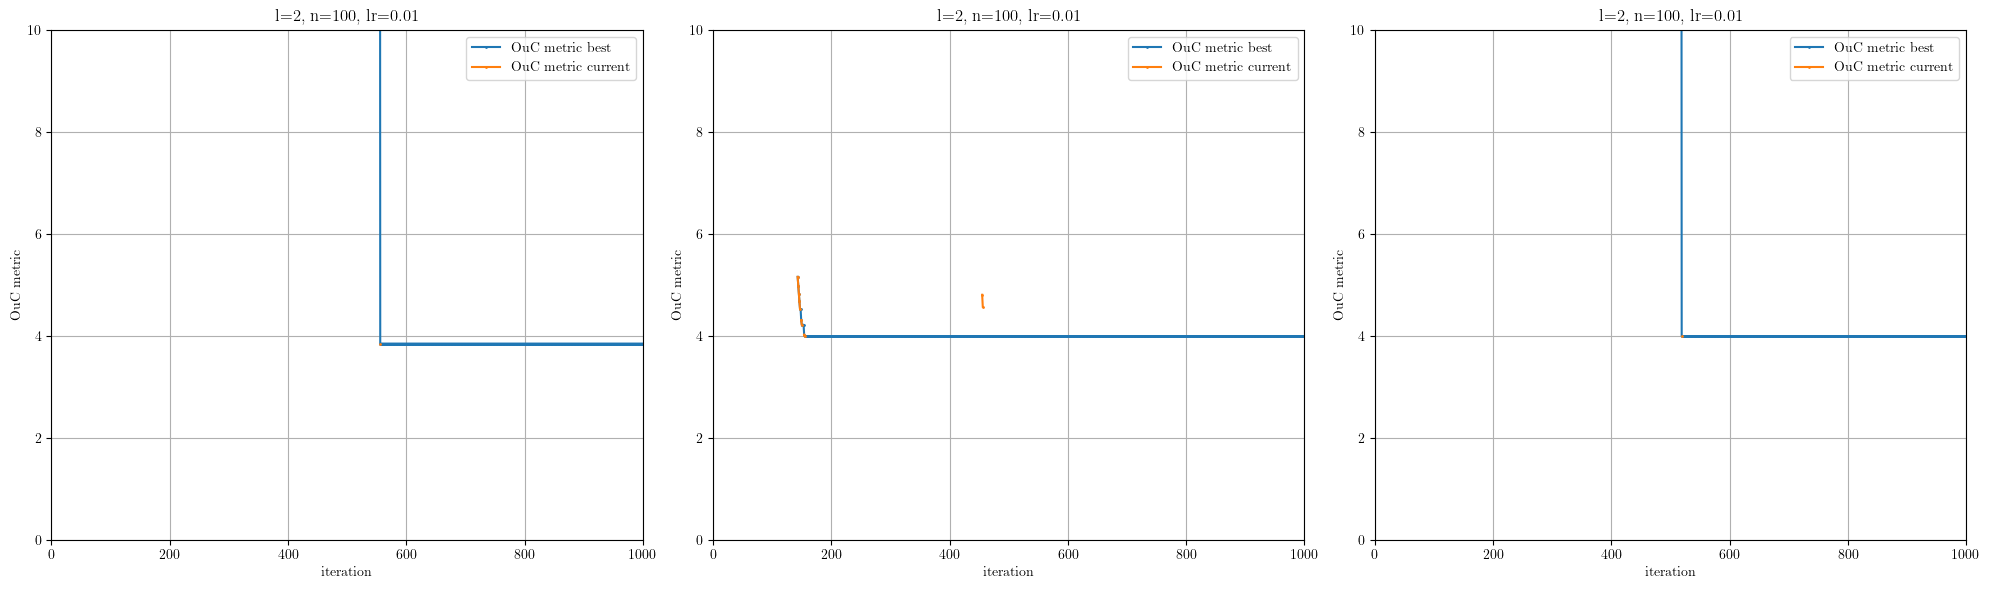

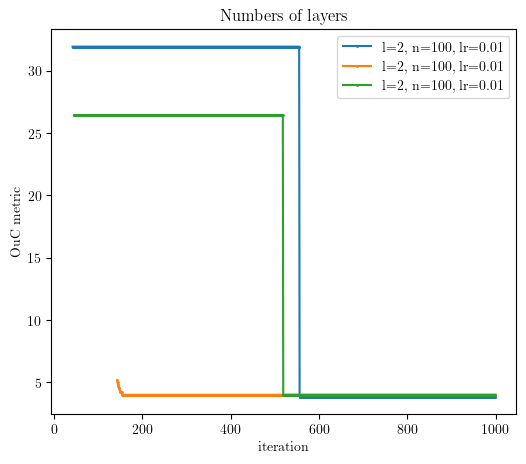

In [47]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 200.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

/tmp/ipykernel_26197/2445299378.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  penalty_mask = torch.tensor(g_values > epsilon, dtype=torch.float).cuda()
/tmp/ipykernel_26197/2445299378.py:167: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logarithmic_penalty = torch.tensor(penalty_mask * (FIXED_PENALTY + PENALTY_SCALE * torch.log(g_values + 1.0))).cuda()


LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.490232 MSE solution: 0.040554346950674065 ratio: 0.003 time: 207.2882628440857
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.368695 MSE solution: 0.04133255114461684 ratio: 0.009 time: 207.49027585983276
LAYERS: 2 NEURONS: 100 LR: 0.01 epsilon: 4.6930456 MSE solution: 0.08054795619192774 ratio: 0.017 time: 206.39159154891968


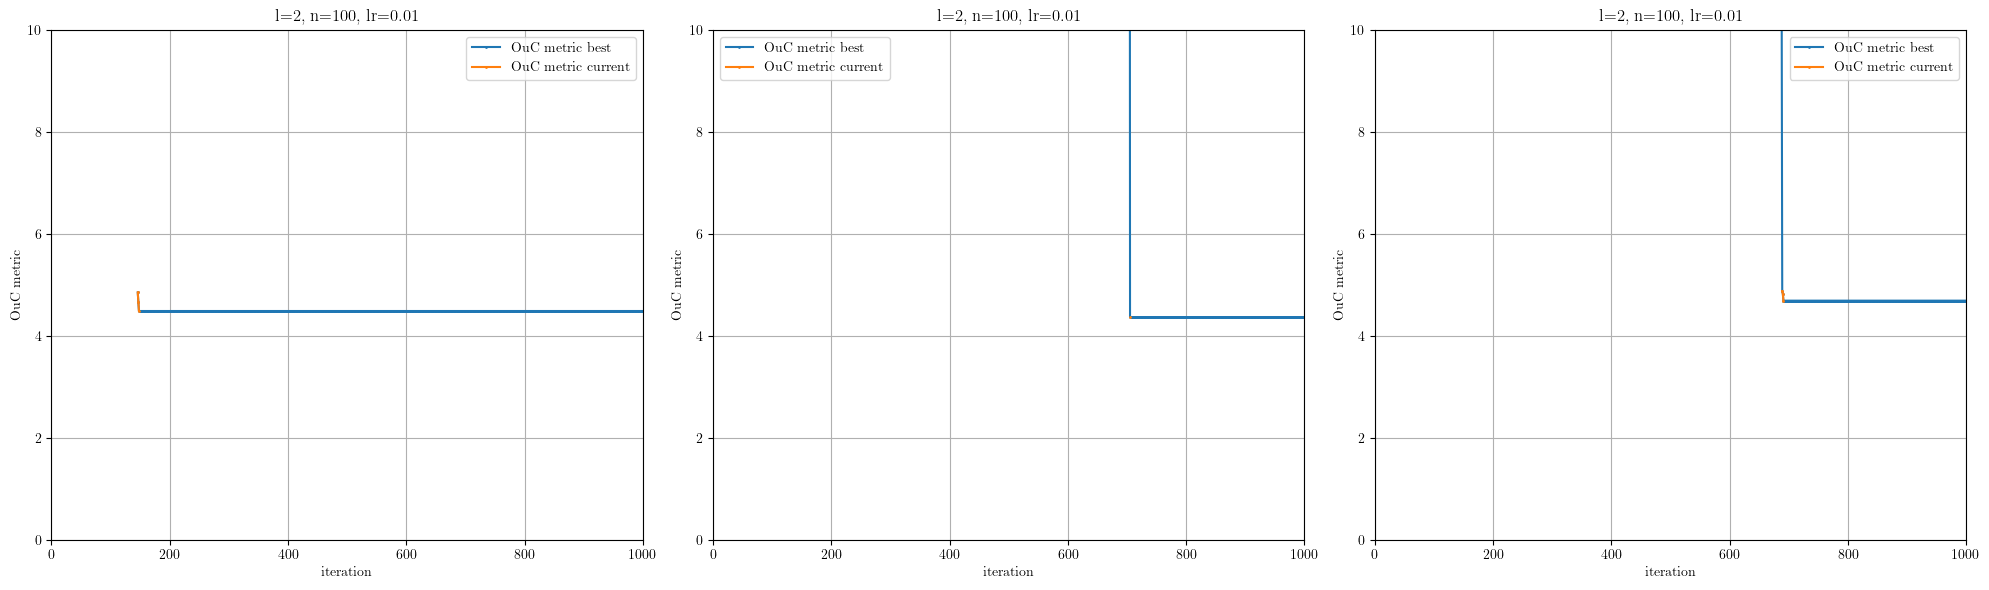

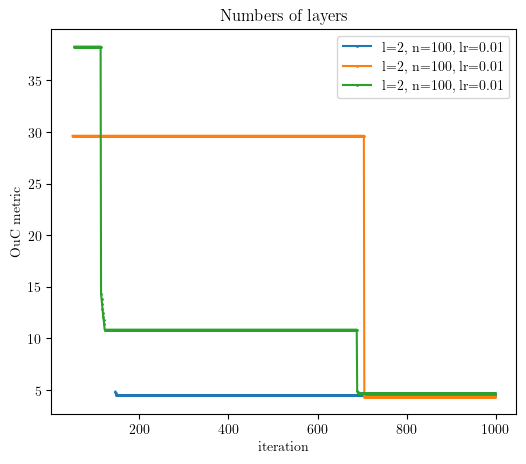

In [48]:
WEIGTHING = 8
CONSTRAINT_WEIGHT = 500.0
res_learning_rate = try_lr([0.01, 0.01, 0.01], 2, 100)
ratio_mean = 0
error_mean = 0
for r in res_learning_rate:
    ratio_mean += r['ratio']
    error_mean += r['mse']
ratio_mean /= len(res_learning_rate)
error_mean /= len(res_learning_rate)
hyperparameter_combinations.append({'WEIGHTING': WEIGTHING, 'CONSTRAINT_WEIGHT': CONSTRAINT_WEIGHT, 'ratio_mean': ratio_mean, 'error_mean': error_mean})
plot_results(res_learning_rate, y_max=10)
plot_result_confrontation(res_learning_rate)

In [49]:
import plotly.express as px
import pandas as pd

# Convert the list of hyperparameter combinations into a DataFrame
df = pd.DataFrame(hyperparameter_combinations)

# Create an interactive scatter plot with ratio_mean on x-axis and error_mean on y-axis
fig = px.scatter(df, 
                 x='error_mean', 
                 y='ratio_mean', 
                 hover_data=['WEIGHTING', 'CONSTRAINT_WEIGHT'],
                 labels={
                     'ratio_mean': 'Ratio Mean',
                     'error_mean': 'Error Mean'
                 },
                 title='Hyperparameter Tuning: Ratio Mean vs. Error Mean')

# Show the interactive plot
fig.show()